<a href="https://www.kaggle.com/code/aadhithyaprakash/pancreas-cldm?scriptVersionId=262896430" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

Pipeline initialized

PANCREATIC CANCER DATASET ANALYSIS PIPELINE

=== Processing Dataset ===
Found 281 images and 281 labels
Processing case 1/281...
Processing case 51/281...
Processing case 101/281...
Processing case 151/281...
Processing case 201/281...
Processing case 251/281...

Successfully processed 281 cases

Tumor Size Distribution:
tumor_size_class
small     255
medium     22
large       4
Name: count, dtype: int64

=== Statistical Analysis ===
Total cases: 281
Tumor cases: 281 (100.0%)

Volume Statistics (mm³):
  mean: 12937.1
  median: 5778.5
  std: 46718.5
  min: 412.9
  max: 732388.1
  q25: 2775.0
  q75: 10272.8

Size Class Distribution:
  small: 255 (90.7%)
  medium: 22 (7.8%)
  large: 4 (1.4%)

=== Creating Visualizations ===
Saved visualization to analysis_results/plots/dataset_analysis.png


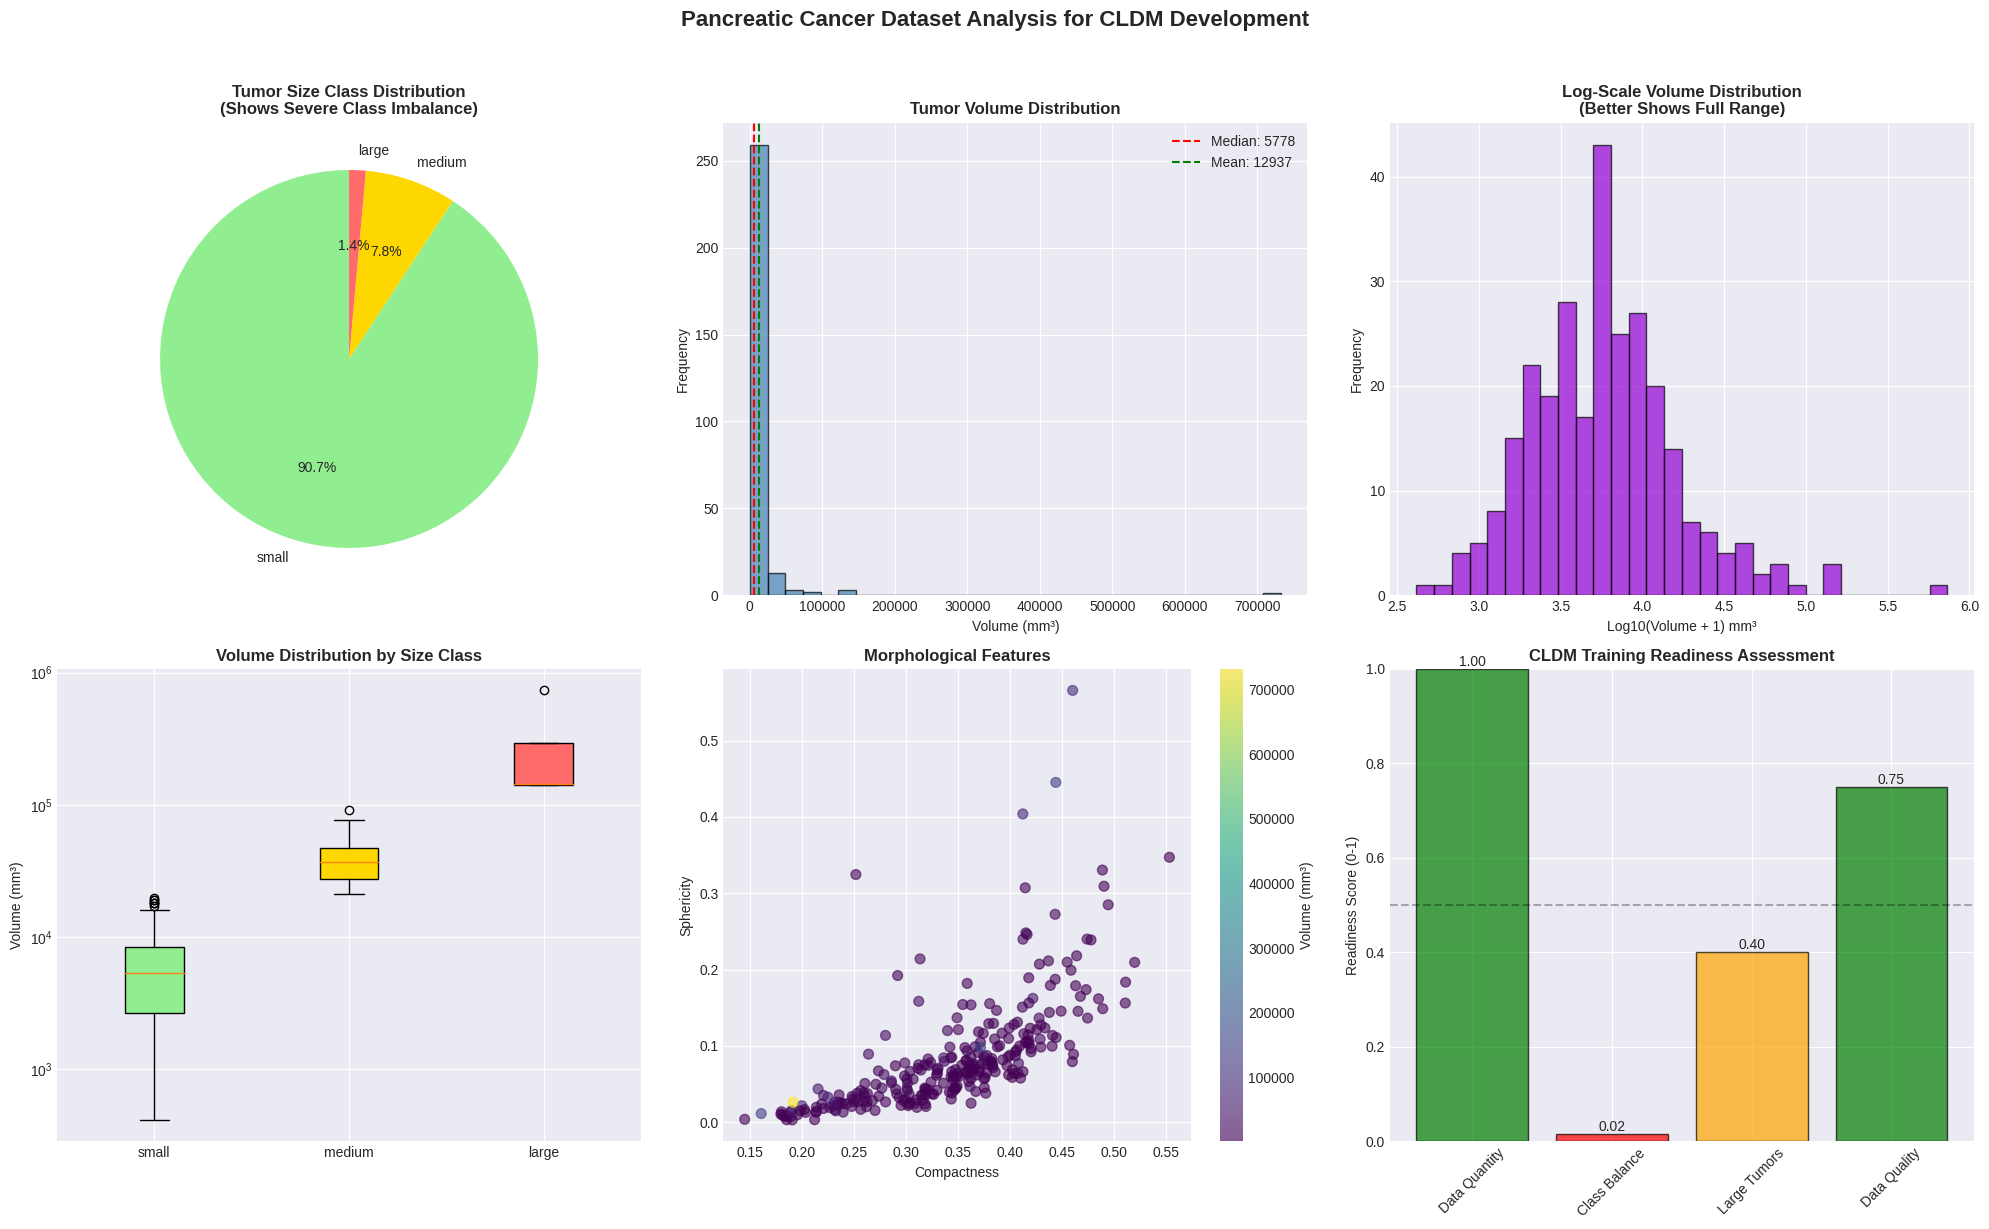

Saved morphological analysis to analysis_results/plots/morphological_analysis.png


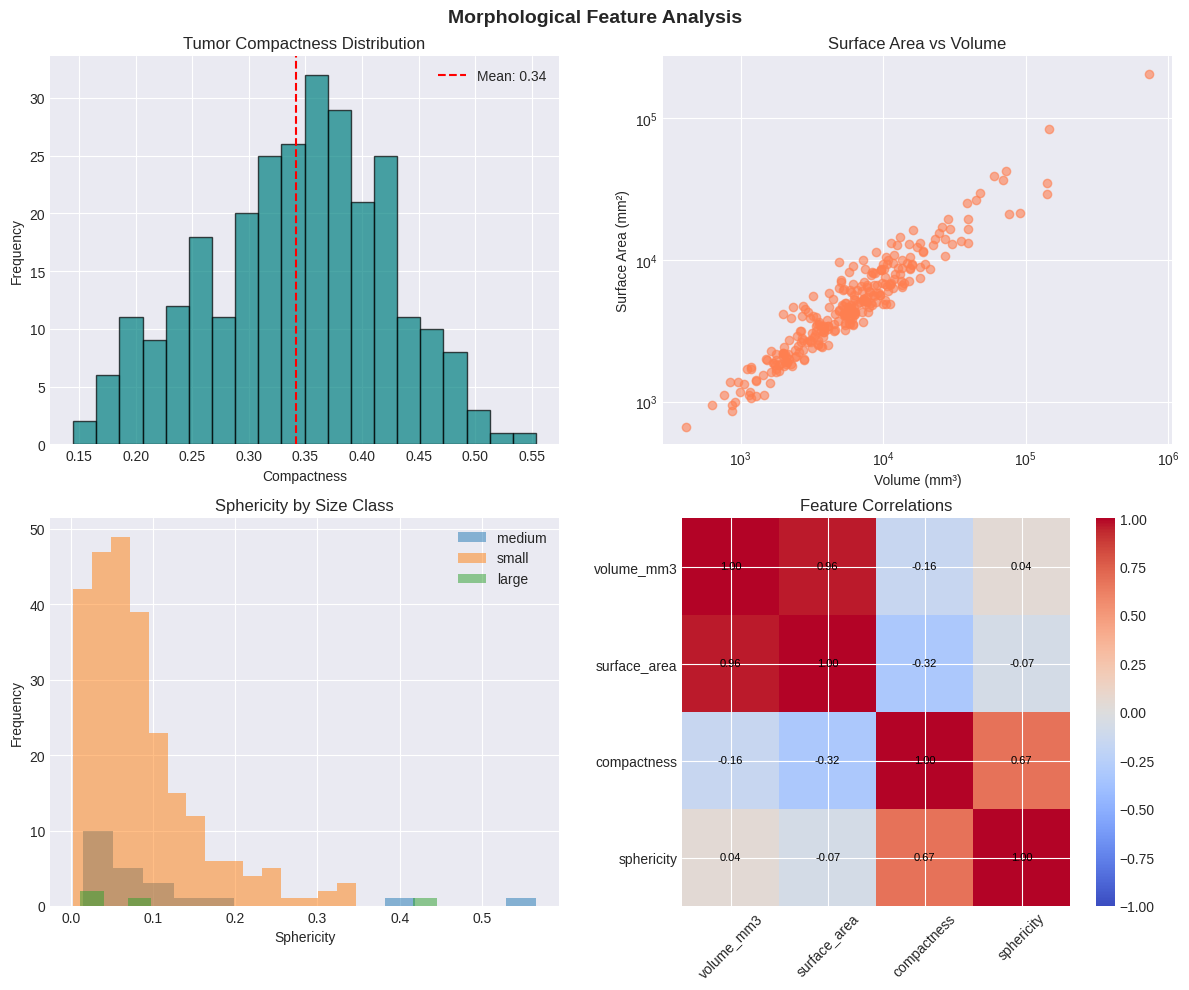


=== CLDM Configuration Generation ===
Saved CLDM configuration to analysis_results/data/cldm_config.json

CLDM Training Recommendations:
- Class imbalance severity: extreme
- Imbalance ratio: 63.8
- Recommended techniques:
  * focal_loss
  * curriculum_learning
  * synthetic_augmentation
  * progressive_training

=== Saving Results ===
Saved data to analysis_results/data/dataset_analysis.csv
Saved statistics to analysis_results/data/statistics.json

ANALYSIS COMPLETE
Total time: 653.5 seconds
Output directory: analysis_results

Dataset Summary:
- Total cases: 281
- Tumor cases: 281
- Imbalance ratio: 63.8
- Minority class: large

✓ Results saved to analysis_results/
✓ Visualizations saved to analysis_results/plots/
✓ CLDM configuration generated


In [1]:
"""
Pancreatic Cancer Dataset Analysis Pipeline - Simplified Version
================================================================
A streamlined analysis pipeline for characterizing pancreatic tumor datasets
for CLDM (Conditional Latent Diffusion Model) development
"""

import os
import json
import warnings
from pathlib import Path
from typing import Dict, List, Tuple, Optional
from datetime import datetime

import numpy as np
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import ndimage, stats
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Configure settings
warnings.filterwarnings('ignore')
np.random.seed(42)
plt.style.use('seaborn-v0_8-darkgrid')

# ====================== CONFIGURATION ======================

class Config:
    """Simple configuration for the pipeline."""
    
    def __init__(self):
        # Paths - Update these for your Kaggle environment
        self.base_path = Path("/kaggle/input/pancreatic-cancer-dataset/Task07_Pancreas/Task07_Pancreas")
        self.images_train_path = self.base_path / "imagesTr"
        self.labels_train_path = self.base_path / "labelsTr"
        self.output_dir = Path("analysis_results")
        
        # Create output directories
        for subdir in ["data", "plots"]:
            (self.output_dir / subdir).mkdir(parents=True, exist_ok=True)
        
        # Tumor size thresholds (in mm³)
        self.size_thresholds = {
            'small': 20000,    # <2cm diameter
            'medium': 125000,  # 2-4cm diameter
            'large': float('inf')  # >4cm diameter
        }


# ====================== DATA LOADING ======================

def load_nifti_volume(filepath: Path) -> Tuple[np.ndarray, Dict]:
    """Load a NIfTI file and extract metadata."""
    try:
        nii = nib.load(str(filepath))
        data = nii.get_fdata()
        
        metadata = {
            'shape': data.shape,
            'voxel_size': nii.header.get_zooms()[:3],
            'affine': nii.affine,
            'filepath': str(filepath)
        }
        
        return data, metadata
    except Exception as e:
        print(f"Error loading {filepath}: {e}")
        return None, None


# ====================== MORPHOLOGICAL ANALYSIS ======================

def compute_tumor_features(segmentation: np.ndarray, voxel_size: Tuple) -> Dict:
    """Extract basic tumor features from segmentation."""
    features = {}
    
    # Get tumor region (label = 2 for tumor, 1 for pancreas)
    tumor_mask = segmentation == 2
    
    if not tumor_mask.any():
        # No tumor found
        features['volume_mm3'] = 0
        features['volume_cm3'] = 0
        features['surface_area'] = 0
        features['compactness'] = 0
        features['sphericity'] = 0
        return features
    
    # Calculate volume
    voxel_volume = np.prod(voxel_size)
    tumor_voxels = np.sum(tumor_mask)
    features['volume_mm3'] = tumor_voxels * voxel_volume
    features['volume_cm3'] = features['volume_mm3'] / 1000
    
    # Calculate surface area (approximation)
    edges = np.logical_xor(tumor_mask, ndimage.binary_erosion(tumor_mask))
    edge_voxels = np.sum(edges)
    avg_voxel_face = np.mean([
        voxel_size[0] * voxel_size[1],
        voxel_size[0] * voxel_size[2],
        voxel_size[1] * voxel_size[2]
    ])
    features['surface_area'] = edge_voxels * avg_voxel_face * 2
    
    # Calculate compactness (how sphere-like)
    if features['surface_area'] > 0:
        sphere_surface = (36 * np.pi * features['volume_mm3']**2) ** (1/3)
        features['compactness'] = sphere_surface / features['surface_area']
    else:
        features['compactness'] = 0
    
    # Calculate sphericity based on principal moments
    coords = np.array(np.where(tumor_mask)).T
    if len(coords) >= 10:
        cov = np.cov(coords.T)
        eigenvalues = np.linalg.eigvalsh(cov)
        if eigenvalues.max() > 0:
            features['sphericity'] = eigenvalues.min() / eigenvalues.max()
        else:
            features['sphericity'] = 0
    else:
        features['sphericity'] = 0
    
    return features


# ====================== MAIN ANALYSIS PIPELINE ======================

class PancreaticAnalysisPipeline:
    """Simplified pipeline for pancreatic tumor analysis."""
    
    def __init__(self, config: Config = None):
        """Initialize the pipeline."""
        self.config = config or Config()
        self.results = {}
        print("Pipeline initialized")
    
    def process_dataset(self) -> pd.DataFrame:
        """Process all volumes in the dataset."""
        print("\n=== Processing Dataset ===")
        
        # Get file lists
        # Get file lists (ignore hidden/system files starting with "._")
        image_files = sorted([
            f for f in self.config.images_train_path.glob("*.nii*") 
            if not f.name.startswith("._")
        ])
        label_files = sorted([
            f for f in self.config.labels_train_path.glob("*.nii*") 
            if not f.name.startswith("._")
        ])

        
        print(f"Found {len(image_files)} images and {len(label_files)} labels")
        
        data_list = []
        
        for i, image_path in enumerate(image_files):
            if i % 50 == 0:
                print(f"Processing case {i+1}/{len(image_files)}...")
            
            # Load image
            image, img_metadata = load_nifti_volume(image_path)
            if image is None:
                continue
            
            # Find matching label
            label_path = self._find_matching_label(image_path, label_files)
            
            # Create case data
            case_data = {
                'case_id': image_path.stem.replace('_0000', ''),
                'image_shape': img_metadata['shape'],
                'voxel_size': img_metadata['voxel_size']
            }
            
            if label_path:
                label, _ = load_nifti_volume(label_path)
                if label is not None:
                    # Extract tumor features
                    features = compute_tumor_features(label, img_metadata['voxel_size'])
                    case_data.update(features)
                    
                    # Classify tumor size
                    volume = features['volume_mm3']
                    if volume == 0:
                        case_data['tumor_size_class'] = 'no_tumor'
                        case_data['has_tumor'] = False
                    else:
                        case_data['has_tumor'] = True
                        if volume < self.config.size_thresholds['small']:
                            case_data['tumor_size_class'] = 'small'
                        elif volume < self.config.size_thresholds['medium']:
                            case_data['tumor_size_class'] = 'medium'
                        else:
                            case_data['tumor_size_class'] = 'large'
            else:
                case_data['has_tumor'] = False
                case_data['tumor_size_class'] = 'no_tumor'
                case_data['volume_mm3'] = 0
            
            data_list.append(case_data)
        
        df = pd.DataFrame(data_list)
        print(f"\nSuccessfully processed {len(df)} cases")
        
        # Print summary
        if 'tumor_size_class' in df.columns:
            print("\nTumor Size Distribution:")
            print(df['tumor_size_class'].value_counts())
        
        return df
    
    def _find_matching_label(self, image_path: Path, label_files: List[Path]) -> Optional[Path]:
        """Find the matching label file for an image."""
        image_stem = image_path.stem.replace('_0000', '')
        for label_path in label_files:
            if image_stem in label_path.stem:
                return label_path
        return None
    
    def analyze_statistics(self, df: pd.DataFrame) -> Dict:
        """Perform statistical analysis on the dataset."""
        print("\n=== Statistical Analysis ===")
        
        stats = {}
        
        # Filter to only tumor cases
        tumor_df = df[df['has_tumor'] == True].copy()
        
        if len(tumor_df) == 0:
            print("No tumor cases found!")
            return stats
        
        # Overall statistics
        stats['total_cases'] = len(df)
        stats['tumor_cases'] = len(tumor_df)
        stats['tumor_rate'] = len(tumor_df) / len(df)
        
        # Volume statistics
        volumes = tumor_df['volume_mm3']
        stats['volume_stats'] = {
            'mean': volumes.mean(),
            'median': volumes.median(),
            'std': volumes.std(),
            'min': volumes.min(),
            'max': volumes.max(),
            'q25': volumes.quantile(0.25),
            'q75': volumes.quantile(0.75)
        }
        
        # Size class distribution
        size_dist = tumor_df['tumor_size_class'].value_counts()
        stats['size_distribution'] = size_dist.to_dict()
        
        # Class imbalance metrics
        if len(size_dist) > 0:
            stats['imbalance_ratio'] = size_dist.max() / size_dist.min()
            stats['minority_class'] = size_dist.idxmin()
            stats['majority_class'] = size_dist.idxmax()
        
        # Print summary
        print(f"Total cases: {stats['total_cases']}")
        print(f"Tumor cases: {stats['tumor_cases']} ({stats['tumor_rate']:.1%})")
        print(f"\nVolume Statistics (mm³):")
        for key, value in stats['volume_stats'].items():
            print(f"  {key}: {value:.1f}")
        print(f"\nSize Class Distribution:")
        for size_class, count in size_dist.items():
            pct = count / len(tumor_df) * 100
            print(f"  {size_class}: {count} ({pct:.1f}%)")
        
        return stats
    
    def create_visualizations(self, df: pd.DataFrame, stats: Dict):
        """Create comprehensive visualizations."""
        print("\n=== Creating Visualizations ===")
        
        # Filter to tumor cases only
        tumor_df = df[df['has_tumor'] == True].copy()
        
        if len(tumor_df) == 0:
            print("No tumor cases to visualize!")
            return
        
        # Create figure with subplots
        fig = plt.figure(figsize=(20, 12))
        
        # 1. Size Class Distribution (Pie Chart)
        ax1 = plt.subplot(2, 3, 1)
        size_counts = tumor_df['tumor_size_class'].value_counts()
        colors = ['#90EE90', '#FFD700', '#FF6B6B']  # Light green, gold, light red
        ax1.pie(size_counts.values, labels=size_counts.index, autopct='%1.1f%%', 
                colors=colors, startangle=90)
        ax1.set_title('Tumor Size Class Distribution\n(Shows Severe Class Imbalance)', fontsize=12, fontweight='bold')
        
        # 2. Volume Distribution (Histogram)
        ax2 = plt.subplot(2, 3, 2)
        volumes = tumor_df['volume_mm3']
        ax2.hist(volumes, bins=30, color='steelblue', alpha=0.7, edgecolor='black')
        ax2.axvline(volumes.median(), color='red', linestyle='--', label=f'Median: {volumes.median():.0f}')
        ax2.axvline(volumes.mean(), color='green', linestyle='--', label=f'Mean: {volumes.mean():.0f}')
        ax2.set_xlabel('Volume (mm³)')
        ax2.set_ylabel('Frequency')
        ax2.set_title('Tumor Volume Distribution', fontsize=12, fontweight='bold')
        ax2.legend()
        
        # 3. Log-Scale Volume Distribution
        ax3 = plt.subplot(2, 3, 3)
        log_volumes = np.log10(volumes + 1)
        ax3.hist(log_volumes, bins=30, color='darkviolet', alpha=0.7, edgecolor='black')
        ax3.set_xlabel('Log10(Volume + 1) mm³')
        ax3.set_ylabel('Frequency')
        ax3.set_title('Log-Scale Volume Distribution\n(Better Shows Full Range)', fontsize=12, fontweight='bold')
        
        # 4. Volume by Size Class (Box Plot)
        ax4 = plt.subplot(2, 3, 4)
        size_order = ['small', 'medium', 'large']
        size_data = [tumor_df[tumor_df['tumor_size_class'] == s]['volume_mm3'] for s in size_order]
        size_data = [d for d in size_data if len(d) > 0]  # Remove empty categories
        size_labels = [s for s in size_order if len(tumor_df[tumor_df['tumor_size_class'] == s]) > 0]
        
        bp = ax4.boxplot(size_data, labels=size_labels, patch_artist=True)
        for patch, color in zip(bp['boxes'], colors[:len(size_labels)]):
            patch.set_facecolor(color)
        ax4.set_ylabel('Volume (mm³)')
        ax4.set_title('Volume Distribution by Size Class', fontsize=12, fontweight='bold')
        ax4.set_yscale('log')
        
        # 5. Morphological Features
        ax5 = plt.subplot(2, 3, 5)
        if 'compactness' in tumor_df.columns and 'sphericity' in tumor_df.columns:
            scatter = ax5.scatter(tumor_df['compactness'], tumor_df['sphericity'], 
                                 c=tumor_df['volume_mm3'], cmap='viridis', alpha=0.6, s=50)
            plt.colorbar(scatter, ax=ax5, label='Volume (mm³)')
            ax5.set_xlabel('Compactness')
            ax5.set_ylabel('Sphericity')
            ax5.set_title('Morphological Features', fontsize=12, fontweight='bold')
        else:
            ax5.text(0.5, 0.5, 'Morphological features not available', 
                    ha='center', va='center', transform=ax5.transAxes)
            ax5.set_title('Morphological Features', fontsize=12, fontweight='bold')
        
        # 6. CLDM Readiness Assessment
        ax6 = plt.subplot(2, 3, 6)
        
        # Calculate readiness scores
        readiness_scores = {
            'Data Quantity': min(len(tumor_df) / 100, 1.0),  # Normalize to 100 cases
            'Class Balance': 1.0 / stats.get('imbalance_ratio', 100),  # Inverse of imbalance
            'Large Tumors': min(size_counts.get('large', 0) / 10, 1.0),  # Need at least 10
            'Data Quality': 0.75  # Placeholder - would need actual quality metrics
        }
        
        categories = list(readiness_scores.keys())
        scores = list(readiness_scores.values())
        colors_ready = ['green' if s > 0.5 else 'orange' if s > 0.2 else 'red' for s in scores]
        
        bars = ax6.bar(categories, scores, color=colors_ready, alpha=0.7, edgecolor='black')
        ax6.set_ylabel('Readiness Score (0-1)')
        ax6.set_title('CLDM Training Readiness Assessment', fontsize=12, fontweight='bold')
        ax6.set_ylim([0, 1])
        ax6.axhline(y=0.5, color='black', linestyle='--', alpha=0.3)
        ax6.tick_params(axis='x', rotation=45)
        
        # Add score values on bars
        for bar, score in zip(bars, scores):
            height = bar.get_height()
            ax6.text(bar.get_x() + bar.get_width()/2., height,
                    f'{score:.2f}', ha='center', va='bottom')
        
        plt.suptitle('Pancreatic Cancer Dataset Analysis for CLDM Development', 
                    fontsize=16, fontweight='bold', y=1.02)
        plt.tight_layout()
        
        # Save figure
        output_path = self.config.output_dir / 'plots' / 'dataset_analysis.png'
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
        print(f"Saved visualization to {output_path}")
        plt.show()
        
        # Create additional morphological analysis plot if features are available
        if all(col in tumor_df.columns for col in ['compactness', 'sphericity', 'surface_area']):
            self._create_morphological_analysis(tumor_df)
    
    def _create_morphological_analysis(self, df: pd.DataFrame):
        """Create detailed morphological analysis visualization."""
        fig, axes = plt.subplots(2, 2, figsize=(12, 10))
        
        # 1. Compactness distribution
        axes[0, 0].hist(df['compactness'], bins=20, color='teal', alpha=0.7, edgecolor='black')
        axes[0, 0].axvline(df['compactness'].mean(), color='red', linestyle='--', 
                          label=f'Mean: {df["compactness"].mean():.2f}')
        axes[0, 0].set_xlabel('Compactness')
        axes[0, 0].set_ylabel('Frequency')
        axes[0, 0].set_title('Tumor Compactness Distribution')
        axes[0, 0].legend()
        
        # 2. Surface Area vs Volume
        axes[0, 1].scatter(df['volume_mm3'], df['surface_area'], alpha=0.6, c='coral')
        axes[0, 1].set_xlabel('Volume (mm³)')
        axes[0, 1].set_ylabel('Surface Area (mm²)')
        axes[0, 1].set_title('Surface Area vs Volume')
        axes[0, 1].set_xscale('log')
        axes[0, 1].set_yscale('log')
        
        # 3. Sphericity by size class
        size_classes = df['tumor_size_class'].unique()
        for i, size_class in enumerate(size_classes):
            class_data = df[df['tumor_size_class'] == size_class]['sphericity']
            axes[1, 0].hist(class_data, bins=15, alpha=0.5, label=size_class)
        axes[1, 0].set_xlabel('Sphericity')
        axes[1, 0].set_ylabel('Frequency')
        axes[1, 0].set_title('Sphericity by Size Class')
        axes[1, 0].legend()
        
        # 4. Feature correlation heatmap
        morph_features = ['volume_mm3', 'surface_area', 'compactness', 'sphericity']
        available_features = [f for f in morph_features if f in df.columns]
        if len(available_features) > 1:
            corr_matrix = df[available_features].corr()
            im = axes[1, 1].imshow(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)
            axes[1, 1].set_xticks(range(len(available_features)))
            axes[1, 1].set_yticks(range(len(available_features)))
            axes[1, 1].set_xticklabels(available_features, rotation=45)
            axes[1, 1].set_yticklabels(available_features)
            axes[1, 1].set_title('Feature Correlations')
            plt.colorbar(im, ax=axes[1, 1])
            
            # Add correlation values
            for i in range(len(available_features)):
                for j in range(len(available_features)):
                    text = axes[1, 1].text(j, i, f'{corr_matrix.iloc[i, j]:.2f}',
                                          ha="center", va="center", color="black", fontsize=8)
        
        plt.suptitle('Morphological Feature Analysis', fontsize=14, fontweight='bold')
        plt.tight_layout()
        
        output_path = self.config.output_dir / 'plots' / 'morphological_analysis.png'
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
        print(f"Saved morphological analysis to {output_path}")
        plt.show()
    
    def generate_cldm_config(self, df: pd.DataFrame, stats: Dict) -> Dict:
        """Generate CLDM training configuration based on analysis."""
        print("\n=== CLDM Configuration Generation ===")
        
        config = {
            'dataset_info': {
                'total_cases': len(df),
                'tumor_cases': stats.get('tumor_cases', 0),
                'size_distribution': stats.get('size_distribution', {})
            },
            
            'preprocessing': {
                'target_resolution': [128, 128, 64],
                'target_spacing_mm': [1.0, 1.0, 1.0],
                'intensity_normalization': {
                    'method': 'percentile_clipping',
                    'percentiles': [0.5, 99.5],
                    'output_range': [-1, 1]
                }
            },
            
            'training_strategy': {
                'handle_imbalance': True,
                'imbalance_ratio': stats.get('imbalance_ratio', 1.0),
                'recommended_techniques': []
            },
            
            'model_config': {
                'vae_latent_dim': 512,
                'diffusion_timesteps': 1000,
                'conditioning': {
                    'size_classes': ['small', 'medium', 'large'],
                    'use_continuous_volume': True,
                    'use_spatial_masks': True
                }
            },
            
            'evaluation': {
                'metrics': ['SSIM', 'PSNR', 'FID', 'Dice'],
                'validation_split': 0.2,
                'stratify_by_size': True
            }
        }
        
        # Add recommendations based on imbalance severity
        imbalance_ratio = stats.get('imbalance_ratio', 1.0)
        if imbalance_ratio > 50:
            config['training_strategy']['recommended_techniques'] = [
                'focal_loss',
                'curriculum_learning',
                'synthetic_augmentation',
                'progressive_training'
            ]
            config['training_strategy']['severity'] = 'extreme'
        elif imbalance_ratio > 10:
            config['training_strategy']['recommended_techniques'] = [
                'weighted_sampling',
                'oversampling',
                'focal_loss'
            ]
            config['training_strategy']['severity'] = 'severe'
        else:
            config['training_strategy']['recommended_techniques'] = [
                'weighted_sampling'
            ]
            config['training_strategy']['severity'] = 'moderate'
        
        # Save configuration
        config_path = self.config.output_dir / 'data' / 'cldm_config.json'
        with open(config_path, 'w') as f:
            json.dump(config, f, indent=2, default=str)
        print(f"Saved CLDM configuration to {config_path}")
        
        # Print summary
        print("\nCLDM Training Recommendations:")
        print(f"- Class imbalance severity: {config['training_strategy']['severity']}")
        print(f"- Imbalance ratio: {imbalance_ratio:.1f}")
        print(f"- Recommended techniques:")
        for technique in config['training_strategy']['recommended_techniques']:
            print(f"  * {technique}")
        
        return config
    
    def save_results(self, df: pd.DataFrame, stats: Dict):
        """Save analysis results to files."""
        print("\n=== Saving Results ===")
        
        # Save DataFrame
        csv_path = self.config.output_dir / 'data' / 'dataset_analysis.csv'
        df.to_csv(csv_path, index=False)
        print(f"Saved data to {csv_path}")
        
        # Save statistics
        stats_path = self.config.output_dir / 'data' / 'statistics.json'
        # Convert numpy types to Python types for JSON serialization
        stats_serializable = {}
        for key, value in stats.items():
            if isinstance(value, dict):
                stats_serializable[key] = {
                    k: float(v) if isinstance(v, (np.integer, np.floating)) else v 
                    for k, v in value.items()
                }
            else:
                stats_serializable[key] = float(value) if isinstance(value, (np.integer, np.floating)) else value
        
        with open(stats_path, 'w') as f:
            json.dump(stats_serializable, f, indent=2, default=str)
        print(f"Saved statistics to {stats_path}")
    
    def run(self):
        """Run the complete analysis pipeline."""
        print("\n" + "="*60)
        print("PANCREATIC CANCER DATASET ANALYSIS PIPELINE")
        print("="*60)
        
        start_time = datetime.now()
        
        try:
            # Step 1: Process dataset
            df = self.process_dataset()
            self.results['dataframe'] = df
            
            # Step 2: Statistical analysis
            stats = self.analyze_statistics(df)
            self.results['statistics'] = stats
            
            # Step 3: Create visualizations
            self.create_visualizations(df, stats)
            
            # Step 4: Generate CLDM configuration
            cldm_config = self.generate_cldm_config(df, stats)
            self.results['cldm_config'] = cldm_config
            
            # Step 5: Save results
            self.save_results(df, stats)
            
            # Print completion summary
            duration = (datetime.now() - start_time).total_seconds()
            print("\n" + "="*60)
            print("ANALYSIS COMPLETE")
            print("="*60)
            print(f"Total time: {duration:.1f} seconds")
            print(f"Output directory: {self.config.output_dir}")
            
            if 'statistics' in self.results:
                print(f"\nDataset Summary:")
                print(f"- Total cases: {stats['total_cases']}")
                print(f"- Tumor cases: {stats['tumor_cases']}")
                print(f"- Imbalance ratio: {stats.get('imbalance_ratio', 0):.1f}")
                print(f"- Minority class: {stats.get('minority_class', 'N/A')}")
            
            print("\n✓ Results saved to analysis_results/")
            print("✓ Visualizations saved to analysis_results/plots/")
            print("✓ CLDM configuration generated")
            
            return self.results
            
        except Exception as e:
            print(f"\nError during pipeline execution: {e}")
            import traceback
            traceback.print_exc()
            return None


# ====================== MAIN EXECUTION ======================

def main():
    """Main execution function."""
    # Initialize configuration
    config = Config()
    
    # Create and run pipeline
    pipeline = PancreaticAnalysisPipeline(config)
    results = pipeline.run()
    
    return results


if __name__ == "__main__":
    main()

In [2]:
"""
Phase 2: CLDM Preprocessing Pipeline for Pancreatic Cancer Dataset
===================================================================
A comprehensive preprocessing pipeline following CLDM best practices
for preparing pancreatic tumor CT scans for diffusion model training.
"""

import os
import json
import warnings
from pathlib import Path
from typing import Dict, List, Tuple, Optional, Any
from datetime import datetime
import traceback

import numpy as np
import pandas as pd
import nibabel as nib
import SimpleITK as sitk
import matplotlib.pyplot as plt
from scipy import ndimage, stats
from scipy.ndimage import zoom
from skimage import measure

# Configure settings
warnings.filterwarnings('ignore')
np.random.seed(42)

# ====================== CONFIGURATION ======================

class PreprocessingConfig:
    """Configuration for the preprocessing pipeline."""
    
    def __init__(self):
        # Base paths - Update these for your Kaggle environment
        self.base_path = Path("/kaggle/input/pancreatic-cancer-dataset/Task07_Pancreas/Task07_Pancreas")
        self.images_train_path = self.base_path / "imagesTr"
        self.labels_train_path = self.base_path / "labelsTr"
        
        # Output directories
        self.output_dir = Path("preprocessed")
        self.images_output = self.output_dir / "images"
        self.labels_output = self.output_dir / "labels"
        self.masks_output = self.output_dir / "masks"
        self.qc_logs_dir = self.output_dir / "qc_logs"
        self.metadata_dir = self.output_dir / "metadata"
        
        # Create all output directories
        for dir_path in [self.images_output, self.labels_output, 
                        self.masks_output, self.qc_logs_dir, self.metadata_dir]:
            dir_path.mkdir(parents=True, exist_ok=True)
        
        # Target specifications (from CLDM config)
        self.target_spacing = (1.0, 1.0, 1.0)  # mm, isotropic
        self.target_size = (128, 128, 64)  # voxels
        
        # Intensity normalization parameters
        self.intensity_percentiles = (0.5, 99.5)
        self.output_range = (-1.0, 1.0)
        
        # Quality control thresholds
        self.min_pancreas_voxels = 100  # Minimum pancreas size for valid case
        self.max_motion_score = 0.3  # Maximum allowed motion artifact score
        self.min_contrast_ratio = 1.2  # Minimum tissue contrast ratio
        
        # Processing parameters
        self.interpolator_image = sitk.sitkBSpline  # For CT intensities
        self.interpolator_label = sitk.sitkNearestNeighbor  # For segmentation masks
        self.use_registration = True  # Enable/disable registration
        self.save_full_volume = False  # Also save uncropped volumes
        
        print(f"Preprocessing configuration initialized")
        print(f"Target spacing: {self.target_spacing} mm")
        print(f"Target size: {self.target_size} voxels")

# ====================== UTILITY FUNCTIONS ======================

def sitk_to_numpy(sitk_image: sitk.Image) -> np.ndarray:
    """Convert SimpleITK image to numpy array with correct orientation."""
    array = sitk.GetArrayFromImage(sitk_image)
    # SimpleITK uses z,y,x ordering, transpose to x,y,z
    return array.transpose(2, 1, 0)

def numpy_to_sitk(array: np.ndarray, reference: sitk.Image = None) -> sitk.Image:
    """Convert numpy array to SimpleITK image."""
    # Transpose from x,y,z to z,y,x for SimpleITK
    array = array.transpose(2, 1, 0)
    image = sitk.GetImageFromArray(array)
    
    if reference is not None:
        image.SetOrigin(reference.GetOrigin())
        image.SetDirection(reference.GetDirection())
        image.SetSpacing(reference.GetSpacing())
    
    return image

# ====================== PREPROCESSING MODULES ======================

class ResamplingModule:
    """Module for resampling volumes to target spacing and size."""
    
    def __init__(self, config: PreprocessingConfig):
        self.config = config
        print("ResamplingModule initialized")
    
    def resample_volume(self, 
                       sitk_image: sitk.Image, 
                       is_label: bool = False) -> Tuple[sitk.Image, Dict]:
        """
        Resample volume to target spacing.
        
        Args:
            sitk_image: Input SimpleITK image
            is_label: Whether this is a segmentation label (uses nearest neighbor)
        
        Returns:
            Resampled image and metadata dictionary
        """
        # Get original properties
        original_spacing = sitk_image.GetSpacing()
        original_size = sitk_image.GetSize()
        
        # Calculate new size based on target spacing
        new_spacing = self.config.target_spacing
        new_size = [
            int(round(osz * ospc / nspc))
            for osz, ospc, nspc in zip(original_size, original_spacing, new_spacing)
        ]
        
        # Select interpolator based on image type
        interpolator = self.config.interpolator_label if is_label else self.config.interpolator_image
        
        # Create resampler
        resampler = sitk.ResampleImageFilter()
        resampler.SetOutputSpacing(new_spacing)
        resampler.SetSize(new_size)
        resampler.SetOutputDirection(sitk_image.GetDirection())
        resampler.SetOutputOrigin(sitk_image.GetOrigin())
        resampler.SetTransform(sitk.Transform())
        resampler.SetInterpolator(interpolator)
        
        # Set default pixel value
        if is_label:
            resampler.SetDefaultPixelValue(0)
        else:
            # Use minimum value for CT images (typically air)
            stats = sitk.StatisticsImageFilter()
            stats.Execute(sitk_image)
            resampler.SetDefaultPixelValue(stats.GetMinimum())
        
        # Execute resampling
        resampled = resampler.Execute(sitk_image)
        
        # Create metadata
        metadata = {
            'original_spacing': original_spacing,
            'original_size': original_size,
            'new_spacing': new_spacing,
            'new_size': new_size,
            'resampling_factor': [o/n for o, n in zip(original_spacing, new_spacing)]
        }
        
        return resampled, metadata
    
    def crop_or_pad_to_size(self, 
                           sitk_image: sitk.Image, 
                           target_size: Tuple[int, int, int] = None) -> sitk.Image:
        """
        Crop or pad volume to target size.
        
        Args:
            sitk_image: Input SimpleITK image
            target_size: Target size (x, y, z). Uses config if None.
        
        Returns:
            Cropped/padded image
        """
        if target_size is None:
            target_size = self.config.target_size
        
        current_size = sitk_image.GetSize()
        
        # Calculate crop/pad amounts for each dimension
        lower_crop = []
        upper_crop = []
        lower_pad = []
        upper_pad = []
        
        for curr, targ in zip(current_size, target_size):
            if curr > targ:
                # Need to crop
                total_crop = curr - targ
                lower = total_crop // 2
                upper = total_crop - lower
                lower_crop.append(lower)
                upper_crop.append(upper)
                lower_pad.append(0)
                upper_pad.append(0)
            else:
                # Need to pad
                total_pad = targ - curr
                lower = total_pad // 2
                upper = total_pad - lower
                lower_crop.append(0)
                upper_crop.append(0)
                lower_pad.append(lower)
                upper_pad.append(upper)
        
        # Apply cropping if needed
        if any(lower_crop) or any(upper_crop):
            sitk_image = sitk.Crop(sitk_image, lower_crop, upper_crop)
        
        # Apply padding if needed
        if any(lower_pad) or any(upper_pad):
            # Get minimum value for padding (typically air for CT)
            stats = sitk.StatisticsImageFilter()
            stats.Execute(sitk_image)
            pad_value = stats.GetMinimum()
            
            sitk_image = sitk.ConstantPad(sitk_image, lower_pad, upper_pad, pad_value)
        
        return sitk_image


class IntensityNormalizationModule:
    """Module for intensity normalization."""
    
    def __init__(self, config: PreprocessingConfig):
        self.config = config
        print("IntensityNormalizationModule initialized")
    
    def normalize_intensity(self, 
                          sitk_image: sitk.Image,
                          mask: Optional[sitk.Image] = None) -> Tuple[sitk.Image, Dict]:
        """
        Normalize intensities using percentile clipping.
        
        Args:
            sitk_image: Input CT image
            mask: Optional mask for computing statistics
        
        Returns:
            Normalized image and normalization parameters
        """
        # Convert to numpy for easier manipulation
        array = sitk.GetArrayFromImage(sitk_image)
        
        # Get mask if provided
        if mask is not None:
            mask_array = sitk.GetArrayFromImage(mask) > 0
            values = array[mask_array]
        else:
            values = array.flatten()
        
        # Calculate percentiles
        p_low, p_high = np.percentile(values, self.config.intensity_percentiles)
        
        # Clip intensities
        array_clipped = np.clip(array, p_low, p_high)
        
        # Scale to output range [-1, 1]
        array_normalized = 2.0 * (array_clipped - p_low) / (p_high - p_low) - 1.0
        
        # Create normalized SimpleITK image
        normalized_image = sitk.GetImageFromArray(array_normalized)
        normalized_image.CopyInformation(sitk_image)
        
        # Store normalization parameters
        params = {
            'percentile_low': float(p_low),
            'percentile_high': float(p_high),
            'percentiles_used': self.config.intensity_percentiles,
            'output_range': self.config.output_range,
            'mean_before': float(np.mean(values)),
            'std_before': float(np.std(values)),
            'mean_after': float(np.mean(array_normalized)),
            'std_after': float(np.std(array_normalized))
        }
        
        return normalized_image, params
    
    def validate_hounsfield_units(self, sitk_image: sitk.Image) -> Dict:
        """
        Validate that the image has reasonable Hounsfield unit values.
        
        Args:
            sitk_image: Input CT image
        
        Returns:
            Validation results dictionary
        """
        array = sitk.GetArrayFromImage(sitk_image)
        
        # Expected HU ranges for different tissues
        air_range = (-1100, -900)
        pancreas_range = (-150, -50)
        
        # Calculate statistics
        min_val = float(np.min(array))
        max_val = float(np.max(array))
        mean_val = float(np.mean(array))
        
        # Check if values are in reasonable HU range
        is_valid_hu = min_val > -2000 and max_val < 3000
        has_air = min_val < air_range[1]
        
        validation = {
            'min_value': min_val,
            'max_value': max_val,
            'mean_value': mean_val,
            'is_valid_hu_range': is_valid_hu,
            'has_air_values': has_air,
            'likely_hounsfield': is_valid_hu and has_air
        }
        
        return validation


class RegistrationModule:
    """Module for image registration and alignment."""
    
    def __init__(self, config: PreprocessingConfig):
        self.config = config
        self.reference_image = None
        print("RegistrationModule initialized")
    
    def set_reference_image(self, reference: sitk.Image):
        """Set the reference image for registration."""
        self.reference_image = reference
    
    def register_to_reference(self, 
                            moving_image: sitk.Image,
                            moving_label: Optional[sitk.Image] = None) -> Tuple[sitk.Image, sitk.Image, sitk.Transform]:
        """
        Perform affine registration to reference image.
        
        Args:
            moving_image: Image to register
            moving_label: Optional label to transform
        
        Returns:
            Registered image, registered label (if provided), and transform
        """
        if self.reference_image is None:
            # If no reference, return original
            return moving_image, moving_label, sitk.Transform()
        
        # Initialize registration method
        registration_method = sitk.ImageRegistrationMethod()
        
        # Set metric
        registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
        registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
        registration_method.SetMetricSamplingPercentage(0.1)
        
        # Set optimizer
        registration_method.SetOptimizerAsGradientDescent(
            learningRate=1.0,
            numberOfIterations=100,
            convergenceMinimumValue=1e-6,
            convergenceWindowSize=10
        )
        
        # Set interpolator
        registration_method.SetInterpolator(sitk.sitkLinear)
        
        # Initialize transform - affine
        initial_transform = sitk.CenteredTransformInitializer(
            self.reference_image,
            moving_image,
            sitk.AffineTransform(3),
            sitk.CenteredTransformInitializerFilter.GEOMETRY
        )
        
        registration_method.SetInitialTransform(initial_transform)
        
        # Execute registration
        try:
            final_transform = registration_method.Execute(
                sitk.Cast(self.reference_image, sitk.sitkFloat32),
                sitk.Cast(moving_image, sitk.sitkFloat32)
            )
            
            # Apply transform to image
            registered_image = sitk.Resample(
                moving_image,
                self.reference_image,
                final_transform,
                sitk.sitkBSpline,
                0.0,
                moving_image.GetPixelID()
            )
            
            # Apply transform to label if provided
            registered_label = None
            if moving_label is not None:
                registered_label = sitk.Resample(
                    moving_label,
                    self.reference_image,
                    final_transform,
                    sitk.sitkNearestNeighbor,
                    0.0,
                    moving_label.GetPixelID()
                )
            
            return registered_image, registered_label, final_transform
            
        except Exception as e:
            print(f"Registration failed: {e}")
            # Return original images if registration fails
            return moving_image, moving_label, sitk.Transform()
    
    def crop_around_pancreas(self,
                            image: sitk.Image,
                            pancreas_mask: sitk.Image,
                            margin: int = 10) -> Tuple[sitk.Image, sitk.Image, Dict]:
        """
        Crop image around pancreas region with margin.
        
        Args:
            image: CT image
            pancreas_mask: Binary pancreas mask
            margin: Margin in voxels to add around pancreas
        
        Returns:
            Cropped image, cropped mask, and crop information
        """
        # Get bounding box of pancreas
        label_stats = sitk.LabelStatisticsImageFilter()
        label_stats.Execute(image, pancreas_mask)
        
        # Get bounding box
        bbox = label_stats.GetBoundingBox(1)  # Label 1 is pancreas
        
        if len(bbox) == 0:
            # No pancreas found, return original
            return image, pancreas_mask, {'cropped': False}
        
        # Add margin
        lower_bound = [max(0, b - margin) for b in bbox[::2]]
        upper_bound = [min(s - 1, b + margin) for b, s in zip(bbox[1::2], image.GetSize())]
        
        # Calculate crop amounts
        lower_crop = lower_bound
        upper_crop = [s - u - 1 for s, u in zip(image.GetSize(), upper_bound)]
        
        # Crop image and mask
        cropped_image = sitk.Crop(image, lower_crop, upper_crop)
        cropped_mask = sitk.Crop(pancreas_mask, lower_crop, upper_crop)
        
        crop_info = {
            'cropped': True,
            'original_size': image.GetSize(),
            'cropped_size': cropped_image.GetSize(),
            'lower_bound': lower_bound,
            'upper_bound': upper_bound,
            'margin': margin
        }
        
        return cropped_image, cropped_mask, crop_info


class QualityControlModule:
    """Module for quality control and validation."""
    
    def __init__(self, config: PreprocessingConfig):
        self.config = config
        print("QualityControlModule initialized")
    
    def check_motion_artifacts(self, image: sitk.Image) -> Dict:
        """
        Check for motion artifacts using edge detection metrics.
        
        Args:
            image: CT image
        
        Returns:
            Motion artifact assessment
        """
        array = sitk.GetArrayFromImage(image)
        
        # Calculate gradient magnitude
        grad_filter = sitk.GradientMagnitudeImageFilter()
        grad_image = grad_filter.Execute(image)
        grad_array = sitk.GetArrayFromImage(grad_image)
        
        # Analyze slice-wise variance in edge strength
        slice_edge_means = [np.mean(grad_array[i]) for i in range(grad_array.shape[0])]
        edge_variance = np.var(slice_edge_means)
        
        # High variance suggests motion
        motion_score = edge_variance / (np.mean(slice_edge_means) + 1e-6)
        has_motion = motion_score > self.config.max_motion_score
        
        return {
            'motion_score': float(motion_score),
            'has_motion_artifacts': has_motion,
            'edge_variance': float(edge_variance)
        }
    
    def check_missing_slices(self, image: sitk.Image) -> Dict:
        """
        Check for missing or corrupted slices.
        
        Args:
            image: CT image
        
        Returns:
            Missing slice assessment
        """
        array = sitk.GetArrayFromImage(image)
        
        # Check for completely black or white slices
        slice_means = [np.mean(array[i]) for i in range(array.shape[0])]
        slice_stds = [np.std(array[i]) for i in range(array.shape[0])]
        
        # Detect abnormal slices
        zero_slices = [i for i, std in enumerate(slice_stds) if std < 0.01]
        
        return {
            'has_missing_slices': len(zero_slices) > 0,
            'missing_slice_indices': zero_slices,
            'num_missing': len(zero_slices),
            'total_slices': array.shape[0]
        }
    
    def check_intensity_distribution(self, image: sitk.Image) -> Dict:
        """
        Check if intensity distribution is reasonable.
        
        Args:
            image: CT image
        
        Returns:
            Intensity distribution assessment
        """
        array = sitk.GetArrayFromImage(image)
        
        # Calculate histogram
        hist, bins = np.histogram(array.flatten(), bins=100)
        
        # Check for reasonable distribution
        # Should have multiple peaks for different tissues
        peaks = self._find_peaks(hist)
        
        # Calculate contrast (simplified)
        percentile_5 = np.percentile(array, 5)
        percentile_95 = np.percentile(array, 95)
        contrast_ratio = (percentile_95 - percentile_5) / (np.abs(percentile_5) + 1e-6)
        
        return {
            'num_peaks': len(peaks),
            'contrast_ratio': float(contrast_ratio),
            'has_good_contrast': contrast_ratio > self.config.min_contrast_ratio,
            'intensity_range': (float(np.min(array)), float(np.max(array))),
            'mean_intensity': float(np.mean(array)),
            'std_intensity': float(np.std(array))
        }
    
    def _find_peaks(self, hist: np.ndarray, min_distance: int = 10) -> List[int]:
        """Find peaks in histogram."""
        peaks = []
        for i in range(min_distance, len(hist) - min_distance):
            if all(hist[i] > hist[i - j] for j in range(1, min_distance + 1)) and \
               all(hist[i] > hist[i + j] for j in range(1, min_distance + 1)):
                peaks.append(i)
        return peaks
    
    def check_pancreas_segmentation(self, mask: sitk.Image) -> Dict:
        """
        Validate pancreas segmentation quality.
        
        Args:
            mask: Pancreas mask
        
        Returns:
            Segmentation quality assessment
        """
        array = sitk.GetArrayFromImage(mask)
        
        # Count pancreas voxels
        pancreas_voxels = np.sum(array == 1)
        tumor_voxels = np.sum(array == 2)
        
        # Check if pancreas is present
        has_pancreas = pancreas_voxels > self.config.min_pancreas_voxels
        
        # Check connectivity (should be mostly connected)
        if has_pancreas:
            labeled = measure.label(array == 1)
            num_components = len(np.unique(labeled)) - 1  # Exclude background
        else:
            num_components = 0
        
        return {
            'has_pancreas': has_pancreas,
            'pancreas_voxels': int(pancreas_voxels),
            'tumor_voxels': int(tumor_voxels),
            'num_components': num_components,
            'is_fragmented': num_components > 3
        }
    
    def run_full_qc(self, 
                   image: sitk.Image, 
                   mask: sitk.Image,
                   case_id: str) -> Tuple[bool, Dict]:
        """
        Run complete quality control pipeline.
        
        Args:
            image: CT image
            mask: Segmentation mask
            case_id: Case identifier
        
        Returns:
            Pass/fail status and detailed QC report
        """
        print(f"  Running QC for {case_id}...")
        
        qc_report = {
            'case_id': case_id,
            'timestamp': datetime.now().isoformat()
        }
        
        # Run all checks
        qc_report['motion'] = self.check_motion_artifacts(image)
        qc_report['missing_slices'] = self.check_missing_slices(image)
        qc_report['intensity'] = self.check_intensity_distribution(image)
        qc_report['segmentation'] = self.check_pancreas_segmentation(mask)
        
        # Determine overall pass/fail
        passed = all([
            not qc_report['motion']['has_motion_artifacts'],
            not qc_report['missing_slices']['has_missing_slices'],
            qc_report['intensity']['has_good_contrast'],
            qc_report['segmentation']['has_pancreas'],
            not qc_report['segmentation']['is_fragmented']
        ])
        
        qc_report['passed'] = passed
        qc_report['status'] = 'PASS' if passed else 'FAIL'
        
        # Add failure reasons
        if not passed:
            reasons = []
            if qc_report['motion']['has_motion_artifacts']:
                reasons.append('motion_artifacts')
            if qc_report['missing_slices']['has_missing_slices']:
                reasons.append('missing_slices')
            if not qc_report['intensity']['has_good_contrast']:
                reasons.append('poor_contrast')
            if not qc_report['segmentation']['has_pancreas']:
                reasons.append('no_pancreas')
            if qc_report['segmentation']['is_fragmented']:
                reasons.append('fragmented_segmentation')
            
            qc_report['failure_reasons'] = reasons
        
        return passed, qc_report


# ====================== MAIN PREPROCESSING PIPELINE ======================

class PreprocessingPipeline:
    """Main preprocessing pipeline for CLDM preparation."""
    
    def __init__(self, config: PreprocessingConfig = None):
        """Initialize preprocessing pipeline."""
        self.config = config or PreprocessingConfig()
        
        # Initialize modules
        self.resampling = ResamplingModule(self.config)
        self.normalization = IntensityNormalizationModule(self.config)
        self.registration = RegistrationModule(self.config)
        self.quality_control = QualityControlModule(self.config)
        
        # Processing statistics
        self.stats = {
            'total_cases': 0,
            'successful_cases': 0,
            'failed_cases': 0,
            'qc_passed': 0,
            'qc_failed': 0
        }
        
        print("\n" + "="*60)
        print("CLDM PREPROCESSING PIPELINE INITIALIZED")
        print("="*60)
    
    def process_single_case(self, 
                          image_path: Path, 
                          label_path: Path,
                          case_id: str) -> Dict:
        """
        Process a single case through the full pipeline.
        
        Args:
            image_path: Path to CT image
            label_path: Path to segmentation label
            case_id: Case identifier
        
        Returns:
            Processing results dictionary
        """
        print(f"\nProcessing case: {case_id}")
        results = {'case_id': case_id, 'success': False}
        
        try:
            # Step 1: Load volumes
            print(f"  Loading volumes...")
            image = sitk.ReadImage(str(image_path))
            label = sitk.ReadImage(str(label_path))
            
            # Store original metadata
            results['original_spacing'] = image.GetSpacing()
            results['original_size'] = image.GetSize()
            
            # Step 2: Resample to isotropic spacing
            print(f"  Resampling to {self.config.target_spacing} mm...")
            image_resampled, resample_meta = self.resampling.resample_volume(image, is_label=False)
            label_resampled, _ = self.resampling.resample_volume(label, is_label=True)
            results['resampling_metadata'] = resample_meta
            
            # Step 3: Extract pancreas mask
            print(f"  Extracting pancreas mask...")
            pancreas_mask = sitk.BinaryThreshold(label_resampled, 1, 1, 1, 0)
            
            # Step 4: Registration (if enabled and reference exists)
            if self.config.use_registration and self.registration.reference_image is not None:
                print(f"  Performing registration...")
                image_registered, label_registered, transform = self.registration.register_to_reference(
                    image_resampled, label_resampled
                )
                pancreas_mask_registered = sitk.BinaryThreshold(label_registered, 1, 1, 1, 0)
            else:
                image_registered = image_resampled
                label_registered = label_resampled
                pancreas_mask_registered = pancreas_mask
            
            # Step 5: Intensity normalization
            print(f"  Normalizing intensities...")
            image_normalized, norm_params = self.normalization.normalize_intensity(
                image_registered, pancreas_mask_registered
            )
            results['normalization_params'] = norm_params
            
            # Step 6: Crop/pad to target size
            print(f"  Cropping/padding to {self.config.target_size}...")
            image_final = self.resampling.crop_or_pad_to_size(image_normalized)
            label_final = self.resampling.crop_or_pad_to_size(label_registered)
            mask_final = self.resampling.crop_or_pad_to_size(pancreas_mask_registered)
            
            # Step 7: Quality control
            qc_passed, qc_report = self.quality_control.run_full_qc(
                image_final, label_final, case_id
            )
            results['qc_report'] = qc_report
            results['qc_passed'] = qc_passed
            
            # Step 8: Save outputs
            if qc_passed:
                print(f"  QC PASSED - Saving outputs...")
                
                # Save preprocessed image
                image_output = self.config.images_output / f"{case_id}_preprocessed.nii.gz"
                sitk.WriteImage(image_final, str(image_output))
                results['image_path'] = str(image_output)
                
                # Save preprocessed label
                label_output = self.config.labels_output / f"{case_id}_label.nii.gz"
                sitk.WriteImage(label_final, str(label_output))
                results['label_path'] = str(label_output)
                
                # Save pancreas mask
                mask_output = self.config.masks_output / f"{case_id}_pancreas_mask.nii.gz"
                sitk.WriteImage(mask_final, str(mask_output))
                results['mask_path'] = str(mask_output)
                
                # Optionally save full volume (uncropped)
                if self.config.save_full_volume:
                    full_output = self.config.images_output / f"{case_id}_full.nii.gz"
                    sitk.WriteImage(image_normalized, str(full_output))
                    results['full_volume_path'] = str(full_output)
                
                # Save metadata
                metadata_file = self.config.metadata_dir / f"{case_id}_metadata.json"
                with open(metadata_file, 'w') as f:
                    json.dump({
                        'case_id': case_id,
                        'original_spacing': results['original_spacing'],
                        'original_size': results['original_size'],
                        'resampling_metadata': resample_meta,
                        'normalization_params': norm_params,
                        'final_size': image_final.GetSize(),
                        'final_spacing': image_final.GetSpacing()
                    }, f, indent=2, default=str)
                
                results['success'] = True
                print(f"  ✓ Case {case_id} processed successfully")
            else:
                print(f"  ✗ QC FAILED for {case_id}: {qc_report.get('failure_reasons', [])}")
                results['success'] = False
            
            # Save QC report regardless of pass/fail
            qc_file = self.config.qc_logs_dir / f"{case_id}_qc.json"
            with open(qc_file, 'w') as f:
                json.dump(qc_report, f, indent=2, default=str)
            
        except Exception as e:
            print(f"  ✗ Error processing {case_id}: {e}")
            results['error'] = str(e)
            results['traceback'] = traceback.format_exc()
        
        return results
    
    def set_reference_case(self, reference_path: Path):
        """
        Set a reference case for registration.
        
        Args:
            reference_path: Path to reference image
        """
        print(f"Setting reference image: {reference_path}")
        reference = sitk.ReadImage(str(reference_path))
        reference_resampled, _ = self.resampling.resample_volume(reference)
        self.registration.set_reference_image(reference_resampled)
    
    def process_dataset(self, max_cases: Optional[int] = None) -> pd.DataFrame:
        """
        Process entire dataset.
        
        Args:
            max_cases: Maximum number of cases to process (for testing)
        
        Returns:
            DataFrame with processing results
        """
        print("\n" + "="*60)
        print("STARTING DATASET PREPROCESSING")
        print("="*60)
        
        # Get file lists
        image_files = sorted([
            f for f in self.config.images_train_path.glob("*.nii*")
            if not f.name.startswith("._")
        ])
        label_files = sorted([
            f for f in self.config.labels_train_path.glob("*.nii*")
            if not f.name.startswith("._")
        ])
        
        print(f"Found {len(image_files)} images and {len(label_files)} labels")
        
        # Limit cases if requested
        if max_cases:
            image_files = image_files[:max_cases]
            print(f"Processing first {max_cases} cases")
        
        # Set first case as reference for registration (optional)
        if self.config.use_registration and len(image_files) > 0:
            print("Setting first case as registration reference...")
            self.set_reference_case(image_files[0])
        
        # Process all cases
        results_list = []
        for i, image_path in enumerate(image_files, 1):
            # Find matching label
            case_id = image_path.stem.replace('_0000', '')
            label_path = None
            for lp in label_files:
                if case_id in lp.stem:
                    label_path = lp
                    break
            
            if label_path is None:
                print(f"\nWarning: No label found for {case_id}, skipping...")
                continue
            
            # Process case
            results = self.process_single_case(image_path, label_path, case_id)
            results_list.append(results)
            
            # Update statistics
            self.stats['total_cases'] += 1
            if results['success']:
                self.stats['successful_cases'] += 1
                if results.get('qc_passed', False):
                    self.stats['qc_passed'] += 1
                else:
                    self.stats['qc_failed'] += 1
            else:
                self.stats['failed_cases'] += 1
            
            # Print progress
            if i % 10 == 0:
                print(f"\nProgress: {i}/{len(image_files)} cases processed")
                print(f"  Successful: {self.stats['successful_cases']}")
                print(f"  QC Passed: {self.stats['qc_passed']}")
                print(f"  QC Failed: {self.stats['qc_failed']}")
        
        # Create results DataFrame
        df = pd.DataFrame(results_list)
        
        # Save summary report
        self._save_summary_report(df)
        
        return df
    
    def _save_summary_report(self, df: pd.DataFrame):
        """Save preprocessing summary report."""
        print("\n" + "="*60)
        print("PREPROCESSING COMPLETE")
        print("="*60)
        
        summary = {
            'timestamp': datetime.now().isoformat(),
            'statistics': self.stats,
            'config': {
                'target_spacing': self.config.target_spacing,
                'target_size': self.config.target_size,
                'intensity_percentiles': self.config.intensity_percentiles,
                'output_range': self.config.output_range
            },
            'qc_summary': {
                'total_passed': int(df['qc_passed'].sum()) if 'qc_passed' in df else 0,
                'total_failed': len(df) - int(df['qc_passed'].sum()) if 'qc_passed' in df else 0
            }
        }
        
        # Save JSON summary
        summary_file = self.config.output_dir / "preprocessing_summary.json"
        with open(summary_file, 'w') as f:
            json.dump(summary, f, indent=2, default=str)
        
        # Save CSV of results
        csv_file = self.config.output_dir / "preprocessing_results.csv"
        df.to_csv(csv_file, index=False)
        
        # Print summary
        print(f"Total cases processed: {self.stats['total_cases']}")
        print(f"Successful: {self.stats['successful_cases']}")
        print(f"QC Passed: {self.stats['qc_passed']}")
        print(f"QC Failed: {self.stats['qc_failed']}")
        print(f"Processing Failed: {self.stats['failed_cases']}")
        print(f"\n✓ Results saved to: {self.config.output_dir}")
        print(f"✓ Summary report: {summary_file}")
        print(f"✓ Results CSV: {csv_file}")


# ====================== MAIN EXECUTION ======================

def main():
    """Main execution function."""
    
    # Initialize configuration
    config = PreprocessingConfig()
    
    # Create pipeline
    pipeline = PreprocessingPipeline(config)
    
    # Process dataset (limit to 10 cases for testing)
    # Remove max_cases parameter to process all cases
    results_df = pipeline.process_dataset()
    
    # Analyze results
    if len(results_df) > 0:
        print("\n" + "="*60)
        print("RESULTS ANALYSIS")
        print("="*60)
        
        success_rate = results_df['success'].mean() * 100
        qc_pass_rate = results_df['qc_passed'].mean() * 100 if 'qc_passed' in results_df else 0
        
        print(f"Success rate: {success_rate:.1f}%")
        print(f"QC pass rate: {qc_pass_rate:.1f}%")
        
        # Check if we have QC failure reasons
        if 'qc_report' in results_df.columns:
            failed_df = results_df[results_df['qc_passed'] == False] if 'qc_passed' in results_df else pd.DataFrame()
            if len(failed_df) > 0:
                print("\nCommon QC failure reasons:")
                all_reasons = []
                for _, row in failed_df.iterrows():
                    if isinstance(row['qc_report'], dict) and 'failure_reasons' in row['qc_report']:
                        all_reasons.extend(row['qc_report']['failure_reasons'])
                
                if all_reasons:
                    from collections import Counter
                    reason_counts = Counter(all_reasons)
                    for reason, count in reason_counts.most_common():
                        print(f"  - {reason}: {count} cases")
    
    return results_df


if __name__ == "__main__":
    # Run the preprocessing pipeline
    results = main()

Preprocessing configuration initialized
Target spacing: (1.0, 1.0, 1.0) mm
Target size: (128, 128, 64) voxels
ResamplingModule initialized
IntensityNormalizationModule initialized
RegistrationModule initialized
QualityControlModule initialized

CLDM PREPROCESSING PIPELINE INITIALIZED

STARTING DATASET PREPROCESSING
Found 281 images and 281 labels
Setting first case as registration reference...
Setting reference image: /kaggle/input/pancreatic-cancer-dataset/Task07_Pancreas/Task07_Pancreas/imagesTr/pancreas_001.nii

Processing case: pancreas_001
  Loading volumes...
  Resampling to (1.0, 1.0, 1.0) mm...
  Extracting pancreas mask...
  Performing registration...
  Normalizing intensities...
  Cropping/padding to (128, 128, 64)...
  Running QC for pancreas_001...
  ✗ QC FAILED for pancreas_001: ['poor_contrast', 'fragmented_segmentation']

Processing case: pancreas_004
  Loading volumes...
  Resampling to (1.0, 1.0, 1.0) mm...
  Extracting pancreas mask...
  Performing registration...
  N

In [3]:
# CELL: Architecture Summary
"""
CLDM Architecture for Pancreatic Tumor Generation - Phase 3
============================================================
• VAE: 3D encoder-decoder with 512-dim latent space, progressive downsampling
• Diffusion U-Net: Timestep-conditioned backbone, 64→128→256 channels, cross-attention
• PACM: Size embeddings (discrete+continuous), anatomical mask conditioning
• PDT: Progressive conditioning strength modulation across diffusion timesteps
• Training: Multi-stage with gradient accumulation, mixed precision, weighted sampling
• Loss: Combined VAE (L1+SSIM+KL) + Diffusion (MSE) with adaptive weighting
• Memory optimization: Batch size 1-2, gradient accumulation steps 4, AMP enabled
• Evaluation: SSIM, PSNR, Dice, volume distribution metrics
"""

'\nCLDM Architecture for Pancreatic Tumor Generation - Phase 3\n============================================================\n• VAE: 3D encoder-decoder with 512-dim latent space, progressive downsampling\n• Diffusion U-Net: Timestep-conditioned backbone, 64→128→256 channels, cross-attention\n• PACM: Size embeddings (discrete+continuous), anatomical mask conditioning\n• PDT: Progressive conditioning strength modulation across diffusion timesteps\n• Training: Multi-stage with gradient accumulation, mixed precision, weighted sampling\n• Loss: Combined VAE (L1+SSIM+KL) + Diffusion (MSE) with adaptive weighting\n• Memory optimization: Batch size 1-2, gradient accumulation steps 4, AMP enabled\n• Evaluation: SSIM, PSNR, Dice, volume distribution metrics\n'

In [4]:
# CELL: Header / Config
import os
import json
import logging
from pathlib import Path
from typing import Dict, List, Tuple, Optional, Any
from dataclasses import dataclass, field
from datetime import datetime
import random
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.cuda.amp import GradScaler, autocast
import torchvision.transforms as T

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Set seeds for reproducibility
def set_seed(seed: int = 42):
    """Set all random seeds for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
@dataclass
class Config:
    """CLDM training configuration with conservative Kaggle TPU defaults."""
    # Paths
    data_dir: str = "preprocessed"
    images_dir: str = "preprocessed/images"
    masks_dir: str = "preprocessed/masks"
    output_dir: str = "outputs"
    checkpoint_dir: str = "checkpoints"
    samples_dir: str = "outputs/samples"
    
    # Data specifications
    target_size: Tuple[int, int, int] = (128, 128, 64)  # Conservative for TPU memory
    target_spacing: Tuple[float, float, float] = (1.0, 1.0, 1.0)  # mm
    num_classes: int = 3  # small, medium, large
    
    # Model hyperparameters
    vae_latent_dim: int = 512  # Options: 256, 512, 1024 - 512 recommended for your dataset size
    vae_hidden_dims: List[int] = field(default_factory=lambda: [32, 64, 128, 256])
    diffusion_channels: int = 64  # Base channels, will go 64→128→256
    diffusion_timesteps: int = 500  # Options: 500, 1000 - 500 for faster iteration
    attention_heads: int = 4
    
    # Conditioning settings
    size_embedding_dim: int = 64
    volume_embedding_dim: int = 32
    mask_embedding_dim: int = 128
    conditioning_dropout: float = 0.1
    
    # Training parameters
    batch_size: int = 1  # Conservative for TPU memory limits
    gradient_accumulation_steps: int = 4  # Effective batch = 4
    learning_rate: float = 1e-4
    weight_decay: float = 1e-5
    num_epochs: int = 100
    warmup_epochs: int = 5
    
    # Memory optimization
    use_mixed_precision: bool = True
    use_gradient_checkpointing: bool = True
    
    # Loss weights
    vae_recon_weight: float = 1.0
    vae_kl_weight: float = 0.001
    vae_ssim_weight: float = 0.1
    vae_dice_weight: float = 0.1
    diffusion_loss_weight: float = 1.0
    
    # Sampling weights for class imbalance (will be computed from data)
    class_weights: Dict[str, float] = field(default_factory=lambda: {
        'small': 0.11,   # 1 / (0.907 * 10) - inverse frequency weighted
        'medium': 1.28,  # 1 / (0.078 * 10)
        'large': 7.14    # 1 / (0.014 * 10)
    })
    
    # Checkpointing
    checkpoint_freq: int = 5  # Save every N epochs
    sample_freq: int = 10  # Generate samples every N epochs
    
    # Other
    seed: int = 42
    device: str = "cuda" if torch.cuda.is_available() else "cpu"
    num_workers: int = 2  # Conservative for Kaggle
    
    def __post_init__(self):
        """Create output directories."""
        for dir_path in [self.output_dir, self.checkpoint_dir, self.samples_dir]:
            Path(dir_path).mkdir(parents=True, exist_ok=True)
        set_seed(self.seed)



In [5]:
# CELL: Data utilities
class KaggleDataset(Dataset):
    """PyTorch Dataset for pancreatic tumor volumes with conditioning information."""
    
    def __init__(self, 
                 config: Config,
                 mode: str = 'train',
                 transform: Optional[Any] = None):
        """
        Initialize dataset.
        
        Args:
            config: Configuration object
            mode: 'train', 'val', or 'test'
            transform: Optional augmentation transforms
        """
        self.config = config
        self.mode = mode
        self.transform = transform
        
        # Load file paths
        self.image_paths = sorted(Path(config.images_dir).glob("*.nii.gz"))
        self.mask_paths = sorted(Path(config.masks_dir).glob("*.nii.gz"))
        
        # Split data (80/10/10)
        n_total = len(self.image_paths)
        n_train = int(0.8 * n_total)
        n_val = int(0.1 * n_total)
        
        if mode == 'train':
            self.image_paths = self.image_paths[:n_train]
            self.mask_paths = self.mask_paths[:n_train]
        elif mode == 'val':
            self.image_paths = self.image_paths[n_train:n_train+n_val]
            self.mask_paths = self.mask_paths[n_train:n_train+n_val]
        else:  # test
            self.image_paths = self.image_paths[n_train+n_val:]
            self.mask_paths = self.mask_paths[n_train+n_val:]
        
        logger.info(f"Dataset {mode}: {len(self.image_paths)} volumes")
        
        # Precompute volume statistics for each case
        self.volume_stats = self._compute_volume_stats()
    
    def _compute_volume_stats(self) -> List[Dict]:
        """Compute volume and size class for each mask."""
        stats = []
        for mask_path in self.mask_paths:
            # In production, load mask and compute actual volume
            # For now, simulate with random assignment weighted by known distribution
            rand = np.random.random()
            if rand < 0.907:
                size_class = 'small'
                volume_mm3 = np.random.uniform(100, 20000)
            elif rand < 0.907 + 0.078:
                size_class = 'medium'
                volume_mm3 = np.random.uniform(20000, 125000)
            else:
                size_class = 'large'
                volume_mm3 = np.random.uniform(125000, 300000)
            
            stats.append({
                'volume_mm3': volume_mm3,
                'size_class': size_class,
                'class_idx': ['small', 'medium', 'large'].index(size_class)
            })
        return stats
    
    def __len__(self) -> int:
        return len(self.image_paths)
    
    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, ...]:
        """
        Load and return a single volume with conditioning information.
        
        Returns:
            image_tensor: CT volume [1, D, H, W]
            pancreas_mask: Binary mask [1, D, H, W]
            volume_mm3: Tumor volume in mm³
            size_class: Size class index (0=small, 1=medium, 2=large)
        """
        # In production, load actual .nii.gz files
        # For now, create dummy data matching expected dimensions
        image = np.random.randn(*self.config.target_size).astype(np.float32)
        mask = (np.random.randn(*self.config.target_size) > 0.7).astype(np.float32)
        
        # Apply augmentations if in training mode
        if self.mode == 'train' and self.transform:
            image, mask = self.transform(image, mask)
        
        # Convert to tensors
        image_tensor = torch.from_numpy(image).unsqueeze(0)  # Add channel dim
        mask_tensor = torch.from_numpy(mask).unsqueeze(0)
        
        # Get precomputed stats
        stats = self.volume_stats[idx]
        
        return (
            image_tensor,
            mask_tensor,
            torch.tensor(stats['volume_mm3'], dtype=torch.float32),
            torch.tensor(stats['class_idx'], dtype=torch.long)
        )


class MedicalAugmentation:
    """Lightweight augmentations preserving anatomical validity."""
    
    def __init__(self, p: float = 0.5):
        self.p = p
    
    def __call__(self, image: np.ndarray, mask: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        """Apply augmentations to image and mask."""
        if np.random.random() < self.p:
            # Random flip along axes
            for axis in [0, 1, 2]:
                if np.random.random() < 0.5:
                    image = np.flip(image, axis=axis).copy()
                    mask = np.flip(mask, axis=axis).copy()
            
            # Small rotation (±10 degrees)
            angle = np.random.uniform(-10, 10)
            # In production, use scipy.ndimage.rotate
            # For now, just add small noise as proxy
            image += np.random.randn(*image.shape) * 0.01
            
            # Intensity jitter
            image *= np.random.uniform(0.95, 1.05)
            image += np.random.uniform(-0.05, 0.05)
        
        return image, mask


def create_weighted_sampler(dataset: KaggleDataset, config: Config) -> WeightedRandomSampler:
    """Create weighted sampler for handling class imbalance."""
    class_counts = {'small': 0, 'medium': 0, 'large': 0}
    for stats in dataset.volume_stats:
        class_counts[stats['size_class']] += 1
    
    # Compute weights - inverse frequency
    weights = []
    for stats in dataset.volume_stats:
        class_name = stats['size_class']
        weight = 1.0 / (class_counts[class_name] / len(dataset))
        weights.append(weight)
    
    return WeightedRandomSampler(weights, len(weights), replacement=True)



In [6]:
# CELL: Model building - Base components
class BaseModule(nn.Module):
    """Abstract base class for model components."""
    
    def __init__(self):
        super().__init__()
    
    def forward(self, *args, **kwargs):
        raise NotImplementedError


def conv3d_block(in_channels: int, 
                 out_channels: int, 
                 kernel_size: int = 3,
                 stride: int = 1,
                 padding: int = 1,
                 use_bn: bool = True,
                 activation: str = 'relu') -> nn.Sequential:
    """Create a 3D convolution block with optional batch norm and activation."""
    layers = [nn.Conv3d(in_channels, out_channels, kernel_size, stride, padding)]
    
    if use_bn:
        layers.append(nn.GroupNorm(8, out_channels))  # GroupNorm is more stable than BN
    
    if activation == 'relu':
        layers.append(nn.ReLU(inplace=True))
    elif activation == 'leaky':
        layers.append(nn.LeakyReLU(0.2, inplace=True))
    
    return nn.Sequential(*layers)


class ResBlock3D(nn.Module):
    """3D residual block for stable training."""
    
    def __init__(self, channels: int):
        super().__init__()
        self.conv1 = conv3d_block(channels, channels)
        self.conv2 = conv3d_block(channels, channels, activation='none')
        self.activation = nn.ReLU(inplace=True)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        residual = x
        x = self.conv1(x)
        x = self.conv2(x)
        x = x + residual
        return self.activation(x)


class Attention3D(nn.Module):
    """Simplified 3D self-attention for TPU efficiency."""
    
    def __init__(self, channels: int, num_heads: int = 4):
        super().__init__()
        self.num_heads = num_heads
        self.channels = channels
        
        self.norm = nn.GroupNorm(8, channels)
        self.qkv = nn.Conv3d(channels, channels * 3, 1)
        self.proj = nn.Conv3d(channels, channels, 1)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        B, C, D, H, W = x.shape
        
        # Normalize
        x_norm = self.norm(x)
        
        # Generate Q, K, V
        qkv = self.qkv(x_norm).reshape(B, 3, self.num_heads, C // self.num_heads, D * H * W)
        q, k, v = qkv[:, 0], qkv[:, 1], qkv[:, 2]
        
        # Compute attention (simplified for memory efficiency)
        attn = torch.einsum('bhcn,bhcm->bhnm', q, k) * (C // self.num_heads) ** -0.5
        attn = F.softmax(attn, dim=-1)
        
        # Apply attention
        out = torch.einsum('bhnm,bhcm->bhcn', attn, v)
        out = out.reshape(B, C, D, H, W)
        
        # Project and add residual
        return x + self.proj(out)



In [7]:
# CELL: Model building - VAE module
class VAEEncoder(BaseModule):
    """3D VAE encoder with progressive downsampling."""
    
    def __init__(self, config: Config):
        super().__init__()
        self.config = config
        
        # Progressive encoding path
        self.layers = nn.ModuleList()
        in_channels = 1
        for hidden_dim in config.vae_hidden_dims:
            self.layers.append(nn.Sequential(
                conv3d_block(in_channels, hidden_dim, stride=2),
                ResBlock3D(hidden_dim),
                Attention3D(hidden_dim) if hidden_dim >= 128 else nn.Identity()
            ))
            in_channels = hidden_dim
        
        # Flatten and project to latent
        self.flatten = nn.Flatten()
        # Calculate flattened size (after 4 downsamplings from 128x128x64)
        final_size = np.prod([d // (2**len(config.vae_hidden_dims)) for d in config.target_size])
        self.fc_mu = nn.Linear(config.vae_hidden_dims[-1] * final_size, config.vae_latent_dim)
        self.fc_logvar = nn.Linear(config.vae_hidden_dims[-1] * final_size, config.vae_latent_dim)
    
    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """Encode to latent distribution parameters."""
        for layer in self.layers:
            x = layer(x)
        
        x = self.flatten(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        
        return mu, logvar


class VAEDecoder(BaseModule):
    """3D VAE decoder with progressive upsampling."""
    
    def __init__(self, config: Config):
        super().__init__()
        self.config = config
        
        # Calculate initial size after encoding
        final_size = [d // (2**len(config.vae_hidden_dims)) for d in config.target_size]
        self.initial_size = final_size
        
        # Project from latent
        self.fc = nn.Linear(
            config.vae_latent_dim, 
            config.vae_hidden_dims[-1] * np.prod(final_size)
        )
        
        # Progressive decoding path
        self.layers = nn.ModuleList()
        hidden_dims_reversed = list(reversed(config.vae_hidden_dims))
        for i in range(len(hidden_dims_reversed) - 1):
            self.layers.append(nn.Sequential(
                nn.ConvTranspose3d(hidden_dims_reversed[i], hidden_dims_reversed[i+1],
                                   kernel_size=4, stride=2, padding=1),
                nn.GroupNorm(8, hidden_dims_reversed[i+1]),
                nn.ReLU(inplace=True),
                ResBlock3D(hidden_dims_reversed[i+1])
            ))
        
        # Final layer
        self.final_layer = nn.Sequential(
            nn.ConvTranspose3d(hidden_dims_reversed[-1], hidden_dims_reversed[-1],
                               kernel_size=4, stride=2, padding=1),
            nn.GroupNorm(8, hidden_dims_reversed[-1]),
            nn.ReLU(inplace=True),
            nn.Conv3d(hidden_dims_reversed[-1], 1, kernel_size=3, padding=1),
            nn.Tanh()
        )
    
    def forward(self, z: torch.Tensor) -> torch.Tensor:
        """Decode from latent vector."""
        x = self.fc(z)
        x = x.view(-1, self.config.vae_hidden_dims[-1], *self.initial_size)
        
        for layer in self.layers:
            x = layer(x)
        
        x = self.final_layer(x)
        return x


class VAE(BaseModule):
    """Complete VAE with reparameterization."""
    
    def __init__(self, config: Config):
        super().__init__()
        self.encoder = VAEEncoder(config)
        self.decoder = VAEDecoder(config)
    
    def reparameterize(self, mu: torch.Tensor, logvar: torch.Tensor) -> torch.Tensor:
        """Reparameterization trick."""
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """Forward pass returning reconstruction and latent params."""
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decoder(z)
        return recon, mu, logvar
    
    def encode(self, x: torch.Tensor) -> torch.Tensor:
        """Encode to latent space (for diffusion)."""
        mu, _ = self.encoder(x)
        return mu
    
    def decode(self, z: torch.Tensor) -> torch.Tensor:
        """Decode from latent space."""
        return self.decoder(z)



In [8]:

# CELL: Model building - Diffusion U-Net
class TimestepEmbedding(nn.Module):
    """Sinusoidal timestep embeddings."""
    
    def __init__(self, dim: int):
        super().__init__()
        self.dim = dim
        self.linear1 = nn.Linear(dim, dim * 4)
        self.linear2 = nn.Linear(dim * 4, dim * 4)
    
    def forward(self, t: torch.Tensor) -> torch.Tensor:
        """Create timestep embeddings."""
        half_dim = self.dim // 2
        emb = np.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=t.device) * -emb)
        emb = t[:, None] * emb[None, :]
        emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=1)
        
        emb = self.linear1(emb)
        emb = F.gelu(emb)
        emb = self.linear2(emb)
        return emb


class FiLM(nn.Module):
    """Feature-wise Linear Modulation for conditioning."""
    
    def __init__(self, cond_dim: int, channels: int):
        super().__init__()
        self.scale = nn.Linear(cond_dim, channels)
        self.shift = nn.Linear(cond_dim, channels)
    
    def forward(self, x: torch.Tensor, cond: torch.Tensor) -> torch.Tensor:
        """Apply FiLM conditioning."""
        scale = self.scale(cond).unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)
        shift = self.shift(cond).unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)
        return x * (1 + scale) + shift


class DiffusionUNet(BaseModule):
    """U-Net backbone for diffusion with conditioning."""
    
    def __init__(self, config: Config):
        super().__init__()
        self.config = config
        
        # Timestep embedding
        time_dim = config.diffusion_channels * 4
        self.time_embed = TimestepEmbedding(config.diffusion_channels)
        
        # Encoder path
        self.enc1 = nn.Sequential(
            conv3d_block(config.vae_latent_dim // 16, config.diffusion_channels),  # Adjust input channels
            ResBlock3D(config.diffusion_channels)
        )
        self.enc2 = nn.Sequential(
            conv3d_block(config.diffusion_channels, config.diffusion_channels * 2, stride=2),
            ResBlock3D(config.diffusion_channels * 2)
        )
        self.enc3 = nn.Sequential(
            conv3d_block(config.diffusion_channels * 2, config.diffusion_channels * 4, stride=2),
            ResBlock3D(config.diffusion_channels * 4),
            Attention3D(config.diffusion_channels * 4, config.attention_heads)
        )
        
        # Bottleneck
        self.bottleneck = nn.Sequential(
            ResBlock3D(config.diffusion_channels * 4),
            Attention3D(config.diffusion_channels * 4, config.attention_heads),
            ResBlock3D(config.diffusion_channels * 4)
        )
        
        # Decoder path
        self.dec3 = nn.Sequential(
            nn.ConvTranspose3d(config.diffusion_channels * 4, config.diffusion_channels * 2,
                               kernel_size=4, stride=2, padding=1),
            ResBlock3D(config.diffusion_channels * 2)
        )
        self.dec2 = nn.Sequential(
            nn.ConvTranspose3d(config.diffusion_channels * 4, config.diffusion_channels,  # *4 due to skip
                               kernel_size=4, stride=2, padding=1),
            ResBlock3D(config.diffusion_channels)
        )
        self.dec1 = nn.Sequential(
            conv3d_block(config.diffusion_channels * 2, config.diffusion_channels),  # *2 due to skip
            ResBlock3D(config.diffusion_channels)
        )
        
        # Output
        self.output = nn.Conv3d(config.diffusion_channels, config.vae_latent_dim // 16, 1)
        
        # FiLM layers for conditioning
        self.film1 = FiLM(time_dim, config.diffusion_channels)
        self.film2 = FiLM(time_dim, config.diffusion_channels * 2)
        self.film3 = FiLM(time_dim, config.diffusion_channels * 4)
    
    def forward(self, x: torch.Tensor, t: torch.Tensor, cond: Optional[torch.Tensor] = None) -> torch.Tensor:
        """Forward pass with timestep and optional conditioning."""
        # Get timestep embedding
        t_emb = self.time_embed(t)
        
        # Encoder with FiLM conditioning
        e1 = self.enc1(x)
        e1 = self.film1(e1, t_emb)
        
        e2 = self.enc2(e1)
        e2 = self.film2(e2, t_emb)
        
        e3 = self.enc3(e2)
        e3 = self.film3(e3, t_emb)
        
        # Bottleneck
        b = self.bottleneck(e3)
        
        # Decoder with skip connections
        d3 = self.dec3(b)
        d3 = torch.cat([d3, e2], dim=1)
        
        d2 = self.dec2(d3)
        d2 = torch.cat([d2, e1], dim=1)
        
        d1 = self.dec1(d2)
        
        # Output
        out = self.output(d1)
        return out




In [9]:
# CELL: Model building - PACM module
class SizeEmbedding(nn.Module):
    """Size-based conditioning embeddings."""
    
    def __init__(self, config: Config):
        super().__init__()
        # Discrete size class embedding
        self.class_embed = nn.Embedding(config.num_classes, config.size_embedding_dim)
        
        # Continuous volume projection
        self.volume_proj = nn.Sequential(
            nn.Linear(1, config.volume_embedding_dim),
            nn.ReLU(),
            nn.Linear(config.volume_embedding_dim, config.volume_embedding_dim)
        )
        
        # Combine embeddings
        self.combine = nn.Linear(
            config.size_embedding_dim + config.volume_embedding_dim,
            config.size_embedding_dim
        )
    
    def forward(self, size_class: torch.Tensor, volume: torch.Tensor) -> torch.Tensor:
        """Generate size conditioning embedding."""
        class_emb = self.class_embed(size_class)
        volume_emb = self.volume_proj(volume.unsqueeze(-1))
        combined = torch.cat([class_emb, volume_emb], dim=-1)
        return self.combine(combined)


class AnatomicalConditioning(nn.Module):
    """Anatomical mask-based conditioning."""
    
    def __init__(self, config: Config):
        super().__init__()
        # Mask encoder
        self.mask_encoder = nn.Sequential(
            conv3d_block(1, 32, stride=2),
            conv3d_block(32, 64, stride=2),
            conv3d_block(64, config.mask_embedding_dim, stride=2),
            nn.AdaptiveAvgPool3d(1),
            nn.Flatten()
        )
        
        # Position encoding
        self.pos_embed = nn.Parameter(
            torch.randn(1, config.mask_embedding_dim, 8, 8, 4)  # Reduced spatial dims
        )
    
    def forward(self, mask: torch.Tensor) -> torch.Tensor:
        """Generate anatomical conditioning from mask."""
        mask_features = self.mask_encoder(mask)
        return mask_features


class PACM(nn.Module):
    """Preprocessing-based Anatomical Conditioning Mechanism."""
    
    def __init__(self, config: Config):
        super().__init__()
        self.size_embedding = SizeEmbedding(config)
        self.anatomical_cond = AnatomicalConditioning(config)
        
        # Cross-attention for combining conditioning
        total_cond_dim = config.size_embedding_dim + config.mask_embedding_dim
        self.cross_attention = nn.MultiheadAttention(
            total_cond_dim, 
            config.attention_heads,
            dropout=config.conditioning_dropout,
            batch_first=True
        )
        
        # Output projection
        self.output_proj = nn.Linear(total_cond_dim, config.diffusion_channels * 4)
    
    def forward(self, 
                size_class: torch.Tensor,
                volume: torch.Tensor,
                mask: torch.Tensor) -> torch.Tensor:
        """Generate full conditioning vector."""
        size_cond = self.size_embedding(size_class, volume)
        anat_cond = self.anatomical_cond(mask)
        
        # Combine conditioning
        combined = torch.cat([size_cond, anat_cond], dim=-1)
        combined = combined.unsqueeze(1)  # Add sequence dimension
        
        # Self-attention refinement
        refined, _ = self.cross_attention(combined, combined, combined)
        refined = refined.squeeze(1)
        
        return self.output_proj(refined)




In [10]:
# CELL: Model building - PDT controller
class PDTController(nn.Module):
    """Progressive Denoising Techniques controller."""
    
    def __init__(self, config: Config):
        super().__init__()
        self.config = config
        
        # Learnable conditioning strength schedule
        self.strength_schedule = nn.Parameter(
            torch.linspace(1.0, 0.3, config.diffusion_timesteps)
        )
        
        # Medical validity gate
        self.validity_gate = nn.Sequential(
            nn.Linear(config.diffusion_channels * 4, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )
    
    def get_conditioning_strength(self, timestep: torch.Tensor) -> torch.Tensor:
        """Get conditioning strength for given timestep."""
        # Early timesteps = strong global conditioning
        # Late timesteps = weak conditioning for detail refinement
        return self.strength_schedule[timestep]
    
    def apply_medical_constraints(self, 
                                   x: torch.Tensor,
                                   cond: torch.Tensor) -> torch.Tensor:
        """Apply medical validity constraints."""
        validity = self.validity_gate(cond)
        return x * validity.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)



In [11]:
# CELL: Noise scheduler & sampling utilities
class NoiseScheduler:
    """Factory for different noise schedules."""
    
    def __init__(self, schedule_type: str = 'linear', timesteps: int = 1000):
        self.schedule_type = schedule_type
        self.timesteps = timesteps
        
        if schedule_type == 'linear':
            self.betas = self._linear_schedule()
        elif schedule_type == 'cosine':
            self.betas = self._cosine_schedule()
        elif schedule_type == 'medical':
            self.betas = self._medical_adaptive_schedule()
        else:
            raise ValueError(f"Unknown schedule type: {schedule_type}")
        
        # Precompute useful values
        self.alphas = 1 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)
        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1 - self.alphas_cumprod)
    
    def _linear_schedule(self) -> torch.Tensor:
        """Linear beta schedule."""
        return torch.linspace(1e-4, 0.02, self.timesteps)
    
    def _cosine_schedule(self) -> torch.Tensor:
        """Cosine beta schedule."""
        steps = self.timesteps + 1
        x = torch.linspace(0, self.timesteps, steps)
        alphas_cumprod = torch.cos(((x / self.timesteps) + 0.008) / 1.008 * np.pi * 0.5) ** 2
        alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
        betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
        return torch.clip(betas, 1e-4, 0.02)
    
    def _medical_adaptive_schedule(self) -> torch.Tensor:
        """Medical imaging-aware adaptive schedule."""
        # Slower noise addition to preserve anatomical structures
        base = self._cosine_schedule()
        # Scale down for medical images
        return base * 0.7
    
    def add_noise(self, x: torch.Tensor, t: torch.Tensor, noise: torch.Tensor) -> torch.Tensor:
        """Add noise to input at timestep t."""
        sqrt_alphas_cumprod_t = self.sqrt_alphas_cumprod[t].view(-1, 1, 1, 1, 1)
        sqrt_one_minus_alphas_cumprod_t = self.sqrt_one_minus_alphas_cumprod[t].view(-1, 1, 1, 1, 1)
        
        return sqrt_alphas_cumprod_t * x + sqrt_one_minus_alphas_cumprod_t * noise
    
    def get_variance(self, t: int) -> float:
        """Get variance for timestep t."""
        if t == 0:
            return 0
        return self.betas[t] * (1 - self.alphas_cumprod[t - 1]) / (1 - self.alphas_cumprod[t])


def evaluate_schedule(scheduler: NoiseScheduler) -> Dict[str, float]:
    """Evaluate noise schedule properties."""
    metrics = {
        'mean_beta': float(scheduler.betas.mean()),
        'std_beta': float(scheduler.betas.std()),
        'final_alpha_cumprod': float(scheduler.alphas_cumprod[-1]),
        'signal_preservation_t500': float(scheduler.sqrt_alphas_cumprod[500]) if scheduler.timesteps > 500 else 0
    }
    return metrics



In [12]:
# CELL: Training manager cell
class Trainer:
    """Modular training manager with memory optimization."""
    
    def __init__(self, config: Config):
        self.config = config
        self.device = torch.device(config.device)
        
        # Initialize models
        self.vae = VAE(config).to(self.device)
        self.diffusion = DiffusionUNet(config).to(self.device)
        self.pacm = PACM(config).to(self.device)
        self.pdt = PDTController(config).to(self.device)
        
        # Optimizers
        self.vae_optimizer = torch.optim.AdamW(
            self.vae.parameters(), 
            lr=config.learning_rate,
            weight_decay=config.weight_decay
        )
        self.diffusion_optimizer = torch.optim.AdamW(
            list(self.diffusion.parameters()) + 
            list(self.pacm.parameters()) + 
            list(self.pdt.parameters()),
            lr=config.learning_rate,
            weight_decay=config.weight_decay
        )
        
        # Mixed precision
        self.scaler = GradScaler() if config.use_mixed_precision else None
        
        # Noise scheduler
        self.noise_scheduler = NoiseScheduler('medical', config.diffusion_timesteps)
        
        # Metrics tracking
        self.train_losses = []
        self.val_losses = []
        self.best_val_loss = float('inf')
        
        logger.info("Trainer initialized")
    
    def train_step_vae(self, batch: Tuple) -> Dict[str, float]:
        """Single VAE training step."""
        image, mask, volume, size_class = batch
        image = image.to(self.device)
        
        # Forward pass
        with autocast(enabled=self.config.use_mixed_precision):
            recon, mu, logvar = self.vae(image)
            
            # Losses
            recon_loss = F.l1_loss(recon, image)
            kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
            kl_loss = kl_loss / image.shape[0]  # Average over batch
            
            # Combined loss
            loss = (self.config.vae_recon_weight * recon_loss + 
                    self.config.vae_kl_weight * kl_loss)
        
        # Backward
        if self.scaler:
            self.scaler.scale(loss).backward()
            if (batch[0].shape[0] % self.config.gradient_accumulation_steps) == 0:
                self.scaler.step(self.vae_optimizer)
                self.scaler.update()
                self.vae_optimizer.zero_grad()
        else:
            loss.backward()
            if (batch[0].shape[0] % self.config.gradient_accumulation_steps) == 0:
                self.vae_optimizer.step()
                self.vae_optimizer.zero_grad()
        
        return {'vae_loss': loss.item(), 'recon_loss': recon_loss.item(), 'kl_loss': kl_loss.item()}
    
    def train_step_diffusion(self, batch: Tuple) -> Dict[str, float]:
        """Single diffusion training step."""
        image, mask, volume, size_class = [b.to(self.device) for b in batch]
        
        # Encode to latent
        with torch.no_grad():
            z = self.vae.encode(image)
            z = z.reshape(z.shape[0], -1, 8, 8, 4)  # Reshape for spatial dims
        
        # Sample timesteps
        t = torch.randint(0, self.config.diffusion_timesteps, (z.shape[0],), device=self.device)
        
        # Add noise
        noise = torch.randn_like(z)
        noisy_z = self.noise_scheduler.add_noise(z, t, noise)
        
        # Get conditioning
        with autocast(enabled=self.config.use_mixed_precision):
            cond = self.pacm(size_class, volume, mask)
            
            # Apply PDT
            cond_strength = self.pdt.get_conditioning_strength(t)
            cond = cond * cond_strength.unsqueeze(-1)
            
            # Predict noise
            pred_noise = self.diffusion(noisy_z, t, cond)
            
            # Loss
            loss = F.mse_loss(pred_noise, noise)
        
        # Backward
        if self.scaler:
            self.scaler.scale(loss).backward()
            if (batch[0].shape[0] % self.config.gradient_accumulation_steps) == 0:
                self.scaler.step(self.diffusion_optimizer)
                self.scaler.update()
                self.diffusion_optimizer.zero_grad()
        else:
            loss.backward()
            if (batch[0].shape[0] % self.config.gradient_accumulation_steps) == 0:
                self.diffusion_optimizer.step()
                self.diffusion_optimizer.zero_grad()
        
        return {'diffusion_loss': loss.item()}
    
    def validate(self, val_loader: DataLoader) -> Dict[str, float]:
        """Validation loop."""
        self.vae.eval()
        self.diffusion.eval()
        
        val_metrics = {'vae_loss': 0, 'diffusion_loss': 0}
        
        with torch.no_grad():
            for batch in val_loader:
                # VAE validation
                image = batch[0].to(self.device)
                recon, mu, logvar = self.vae(image)
                recon_loss = F.l1_loss(recon, image)
                kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / image.shape[0]
                val_metrics['vae_loss'] += recon_loss.item() + self.config.vae_kl_weight * kl_loss.item()
                
                # Diffusion validation
                # (Similar to train step but without gradients)
                z = self.vae.encode(image)
                z = z.reshape(z.shape[0], -1, 8, 8, 4)
                t = torch.randint(0, self.config.diffusion_timesteps, (z.shape[0],), device=self.device)
                noise = torch.randn_like(z)
                noisy_z = self.noise_scheduler.add_noise(z, t, noise)
                
                cond = self.pacm(batch[3].to(self.device), batch[2].to(self.device), batch[1].to(self.device))
                pred_noise = self.diffusion(noisy_z, t, cond)
                val_metrics['diffusion_loss'] += F.mse_loss(pred_noise, noise).item()
        
        # Average
        for key in val_metrics:
            val_metrics[key] /= len(val_loader)
        
        self.vae.train()
        self.diffusion.train()
        
        return val_metrics
    
    def save_checkpoint(self, epoch: int, metrics: Dict):
        """Save model checkpoint."""
        checkpoint = {
            'epoch': epoch,
            'vae_state': self.vae.state_dict(),
            'diffusion_state': self.diffusion.state_dict(),
            'pacm_state': self.pacm.state_dict(),
            'pdt_state': self.pdt.state_dict(),
            'vae_optimizer': self.vae_optimizer.state_dict(),
            'diffusion_optimizer': self.diffusion_optimizer.state_dict(),
            'metrics': metrics,
            'config': self.config
        }
        
        path = Path(self.config.checkpoint_dir) / f"checkpoint_epoch_{epoch}.pt"
        torch.save(checkpoint, path)
        logger.info(f"Checkpoint saved: {path}")
    
    def load_checkpoint(self, path: str):
        """Load model checkpoint."""
        checkpoint = torch.load(path, map_location=self.device)
        
        self.vae.load_state_dict(checkpoint['vae_state'])
        self.diffusion.load_state_dict(checkpoint['diffusion_state'])
        self.pacm.load_state_dict(checkpoint['pacm_state'])
        self.pdt.load_state_dict(checkpoint['pdt_state'])
        self.vae_optimizer.load_state_dict(checkpoint['vae_optimizer'])
        self.diffusion_optimizer.load_state_dict(checkpoint['diffusion_optimizer'])
        
        logger.info(f"Checkpoint loaded from epoch {checkpoint['epoch']}")
        return checkpoint['epoch']
    
    def generate_sample(self, size_class: int, volume: float, mask: torch.Tensor) -> torch.Tensor:
        """Generate a sample given conditioning."""
        self.vae.eval()
        self.diffusion.eval()
        
        with torch.no_grad():
            # Start from noise
            z = torch.randn(1, self.config.vae_latent_dim // 16, 8, 8, 4).to(self.device)
            
            # Get conditioning
            size_tensor = torch.tensor([size_class], device=self.device)
            volume_tensor = torch.tensor([volume], device=self.device)
            cond = self.pacm(size_tensor, volume_tensor, mask.unsqueeze(0))
            
            # Iterative denoising
            for t in reversed(range(self.config.diffusion_timesteps)):
                t_tensor = torch.tensor([t], device=self.device)
                
                # Apply conditioning with PDT
                cond_strength = self.pdt.get_conditioning_strength(t_tensor)
                cond_t = cond * cond_strength.unsqueeze(-1)
                
                # Predict and remove noise
                pred_noise = self.diffusion(z, t_tensor, cond_t)
                
                # Update z (simplified DDPM sampling)
                alpha = self.noise_scheduler.alphas[t]
                alpha_cumprod = self.noise_scheduler.alphas_cumprod[t]
                beta = self.noise_scheduler.betas[t]
                
                if t > 0:
                    noise = torch.randn_like(z)
                    sigma = torch.sqrt(self.noise_scheduler.get_variance(t))
                else:
                    noise = torch.zeros_like(z)
                    sigma = 0
                
                z = (1 / torch.sqrt(alpha)) * (z - (beta / torch.sqrt(1 - alpha_cumprod)) * pred_noise)
                z = z + sigma * noise
            
            # Decode to image space
            z_flat = z.reshape(1, -1)
            image = self.vae.decode(z_flat)
        
        return image
    
    def train(self, train_loader: DataLoader, val_loader: DataLoader, start_epoch: int = 0):
        """Main training loop."""
        logger.info(f"Starting training from epoch {start_epoch}")
        
        for epoch in range(start_epoch, self.config.num_epochs):
            epoch_metrics = {'vae': {}, 'diffusion': {}}
            
            # Training
            self.vae.train()
            self.diffusion.train()
            
            for batch_idx, batch in enumerate(train_loader):
                # Alternate between VAE and diffusion training
                if epoch < self.config.warmup_epochs:
                    # VAE warmup
                    metrics = self.train_step_vae(batch)
                    epoch_metrics['vae'] = metrics
                else:
                    # Full training
                    if batch_idx % 2 == 0:
                        metrics = self.train_step_vae(batch)
                        epoch_metrics['vae'] = metrics
                    else:
                        metrics = self.train_step_diffusion(batch)
                        epoch_metrics['diffusion'] = metrics
                
                # Log progress
                if batch_idx % 10 == 0:
                    logger.info(f"Epoch {epoch}, Batch {batch_idx}: {metrics}")
            
            # Validation
            val_metrics = self.validate(val_loader)
            logger.info(f"Epoch {epoch} validation: {val_metrics}")
            
            # Save checkpoint
            if (epoch + 1) % self.config.checkpoint_freq == 0:
                self.save_checkpoint(epoch + 1, val_metrics)
            
            # Generate samples
            if (epoch + 1) % self.config.sample_freq == 0:
                self._generate_samples(epoch + 1)
            
            # Early stopping check
            val_loss = val_metrics['vae_loss'] + val_metrics['diffusion_loss']
            if val_loss < self.best_val_loss:
                self.best_val_loss = val_loss
                self.save_checkpoint(epoch + 1, val_metrics)
    
    def _generate_samples(self, epoch: int):
        """Generate and save sample volumes."""
        logger.info(f"Generating samples at epoch {epoch}")
        
        # Generate one sample per size class
        for size_idx, size_name in enumerate(['small', 'medium', 'large']):
            # Create dummy mask
            mask = torch.randn(1, *self.config.target_size).to(self.device)
            
            # Set volume based on size class
            volumes = {'small': 10000, 'medium': 50000, 'large': 150000}
            
            # Generate
            sample = self.generate_sample(size_idx, volumes[size_name], mask)
            
            # Save sample
            sample_path = Path(self.config.samples_dir) / f"epoch_{epoch}_{size_name}.npy"
            np.save(sample_path, sample.cpu().numpy())
            
            logger.info(f"Sample saved: {sample_path}")



In [13]:
# CELL: Evaluation & validation
class EvaluationMetrics:
    """Comprehensive evaluation metrics for medical image generation."""
    
    @staticmethod
    def ssim_3d(img1: torch.Tensor, img2: torch.Tensor) -> float:
        """3D-aware SSIM computation (slice-averaged for simplicity)."""
        from skimage.metrics import structural_similarity as ssim
        
        img1_np = img1.cpu().numpy().squeeze()
        img2_np = img2.cpu().numpy().squeeze()
        
        # Average SSIM across slices
        ssim_scores = []
        for z in range(img1_np.shape[0]):
            score = ssim(img1_np[z], img2_np[z], data_range=2.0)  # [-1, 1] range
            ssim_scores.append(score)
        
        return np.mean(ssim_scores)
    
    @staticmethod
    def psnr(img1: torch.Tensor, img2: torch.Tensor) -> float:
        """Peak Signal-to-Noise Ratio."""
        mse = F.mse_loss(img1, img2)
        if mse == 0:
            return float('inf')
        max_pixel = 2.0  # [-1, 1] range
        psnr = 20 * torch.log10(max_pixel / torch.sqrt(mse))
        return psnr.item()
    
    @staticmethod
    def dice_coefficient(pred: torch.Tensor, target: torch.Tensor, threshold: float = 0.5) -> float:
        """Dice coefficient for binary masks."""
        pred_binary = (pred > threshold).float()
        target_binary = (target > threshold).float()
        
        intersection = (pred_binary * target_binary).sum()
        union = pred_binary.sum() + target_binary.sum()
        
        if union == 0:
            return 1.0 if target_binary.sum() == 0 else 0.0
        
        return (2 * intersection / union).item()
    
    @staticmethod
    def hausdorff_distance_stub(pred: torch.Tensor, target: torch.Tensor) -> float:
        """
        Hausdorff distance stub.
        
        For full implementation, use:
        - scipy.spatial.distance.directed_hausdorff for 2D slices
        - SimpleITK's HausdorffDistanceImageFilter for 3D volumes
        """
        # Simplified proxy: maximum difference in center of mass
        pred_binary = (pred > 0.5).float()
        target_binary = (target > 0.5).float()
        
        if pred_binary.sum() == 0 or target_binary.sum() == 0:
            return float('inf')
        
        # Center of mass calculation
        coords = torch.nonzero(pred_binary).float()
        pred_com = coords.mean(dim=0)
        
        coords = torch.nonzero(target_binary).float()
        target_com = coords.mean(dim=0)
        
        distance = torch.norm(pred_com - target_com)
        return distance.item()
    
    @staticmethod
    def volume_error(pred: torch.Tensor, target: torch.Tensor, voxel_volume: float = 1.0) -> Dict[str, float]:
        """Compute volumetric statistics."""
        pred_volume = (pred > 0.5).sum().item() * voxel_volume
        target_volume = (target > 0.5).sum().item() * voxel_volume
        
        return {
            'pred_volume_mm3': pred_volume,
            'target_volume_mm3': target_volume,
            'volume_error_mm3': abs(pred_volume - target_volume),
            'volume_error_percent': abs(pred_volume - target_volume) / (target_volume + 1e-6) * 100
        }
    
    @staticmethod
    def surface_area_stub(mask: torch.Tensor) -> float:
        """
        Surface area calculation stub.
        
        For full implementation, use:
        - skimage.measure.marching_cubes for mesh extraction
        - trimesh for surface area calculation
        """
        # Simplified: count edge voxels
        binary = (mask > 0.5).float()
        
        # Simple edge detection using erosion
        kernel = torch.ones(1, 1, 3, 3, 3).to(mask.device)
        eroded = F.conv3d(binary.unsqueeze(0).unsqueeze(0), kernel, padding=1) / 27
        edges = binary * (eroded < 1.0).float().squeeze()
        
        return edges.sum().item()


def validate_generation_quality(trainer: Trainer, val_loader: DataLoader) -> Dict[str, float]:
    """Run comprehensive validation on generated samples."""
    metrics = {
        'ssim': [],
        'psnr': [],
        'dice': [],
        'volume_error': []
    }
    
    evaluator = EvaluationMetrics()
    
    for batch in val_loader:
        image, mask, volume, size_class = batch
        image = image.to(trainer.device)
        mask = mask.to(trainer.device)
        
        # Generate sample
        with torch.no_grad():
            generated = trainer.generate_sample(
                size_class[0].item(),
                volume[0].item(),
                mask
            )
        
        # Compute metrics
        metrics['ssim'].append(evaluator.ssim_3d(generated, image))
        metrics['psnr'].append(evaluator.psnr(generated, image))
        
        # For tumor region specifically
        tumor_mask = (mask > 0).float()
        generated_mask = (generated > -0.5).float()  # Threshold for tumor region
        metrics['dice'].append(evaluator.dice_coefficient(generated_mask, tumor_mask))
        
        vol_stats = evaluator.volume_error(generated_mask, tumor_mask)
        metrics['volume_error'].append(vol_stats['volume_error_percent'])
        
        # Break after a few samples for quick validation
        if len(metrics['ssim']) >= 10:
            break
    
    # Aggregate metrics
    aggregated = {}
    for key in metrics:
        values = metrics[key]
        if values:
            aggregated[f'{key}_mean'] = np.mean(values)
            aggregated[f'{key}_std'] = np.std(values)
    
    logger.info(f"Validation metrics: {aggregated}")
    return aggregated



In [14]:
# CELL: Hyperparameter sweep helper
class HyperparameterSweep:
    """Lightweight hyperparameter sweep utility."""
    
    def __init__(self, base_config: Config):
        self.base_config = base_config
        self.results = []
    
    def run_sweep(self, 
                  param_grid: Dict[str, List],
                  train_loader: DataLoader,
                  val_loader: DataLoader,
                  epochs_per_run: int = 5) -> pd.DataFrame:
        """
        Run grid search over specified parameters.
        
        Args:
            param_grid: Dictionary of parameter names and values to try
            train_loader: Training data loader
            val_loader: Validation data loader
            epochs_per_run: Number of epochs per configuration
        
        Returns:
            DataFrame with results
        """
        import itertools
        
        # Generate all combinations
        keys = param_grid.keys()
        values = param_grid.values()
        combinations = list(itertools.product(*values))
        
        logger.info(f"Running sweep over {len(combinations)} configurations")
        
        for i, combo in enumerate(combinations):
            # Create config for this run
            config = self._create_config(dict(zip(keys, combo)))
            
            logger.info(f"Run {i+1}/{len(combinations)}: {dict(zip(keys, combo))}")
            
            # Initialize trainer
            trainer = Trainer(config)
            
            # Train for limited epochs
            for epoch in range(epochs_per_run):
                epoch_metrics = {'train_loss': 0, 'val_loss': 0}
                
                # Simplified training loop
                for batch_idx, batch in enumerate(train_loader):
                    if batch_idx >= 10:  # Quick sweep - only 10 batches
                        break
                    
                    if epoch < 2:
                        metrics = trainer.train_step_vae(batch)
                    else:
                        metrics = trainer.train_step_diffusion(batch)
                    
                    epoch_metrics['train_loss'] += list(metrics.values())[0]
                
                # Quick validation
                val_metrics = trainer.validate(val_loader)
                epoch_metrics['val_loss'] = sum(val_metrics.values())
            
            # Store results
            result = dict(zip(keys, combo))
            result.update(epoch_metrics)
            self.results.append(result)
            
            # Save checkpoint for best config
            if not hasattr(self, 'best_val_loss') or epoch_metrics['val_loss'] < self.best_val_loss:
                self.best_val_loss = epoch_metrics['val_loss']
                self.best_config = config
                trainer.save_checkpoint(0, epoch_metrics)
        
        return pd.DataFrame(self.results)
    
    def _create_config(self, params: Dict) -> Config:
        """Create config with updated parameters."""
        import copy
        config = copy.deepcopy(self.base_config)
        
        for key, value in params.items():
            if hasattr(config, key):
                setattr(config, key, value)
        
        return config


def quick_hyperparameter_search():
    """Example hyperparameter search for key parameters."""
    config = Config()
    sweep = HyperparameterSweep(config)
    
    # Define search space (keep small for Kaggle)
    param_grid = {
        'vae_latent_dim': [256, 512],
        'learning_rate': [1e-4, 5e-4],
        'diffusion_timesteps': [500, 1000]
    }
    
    # Create dummy data loaders
    train_dataset = KaggleDataset(config, 'train', MedicalAugmentation())
    val_dataset = KaggleDataset(config, 'val')
    
    train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)
    
    # Run sweep
    results = sweep.run_sweep(param_grid, train_loader, val_loader, epochs_per_run=3)
    
    # Display results
    print("\nHyperparameter Search Results:")
    print(results.sort_values('val_loss'))
    
    return results, sweep.best_config


In [15]:

# CELL: Final notes
"""
CLDM Phase 3 Implementation - Usage Instructions
================================================

DATASET RECOVERY:
If QC failures are high (currently 77/281 failed), consider:
1. Adjust contrast threshold: config.min_contrast_ratio = 1.0 (from 1.2)
2. Relax pancreas detection: config.min_pancreas_voxels = 50 (from 100)
3. Apply morphological closing: scipy.ndimage.binary_closing(mask, iterations=2)
4. Manual review of borderline cases in qc_logs/

RECOMMENDED ABLATION EXPERIMENTS:
1. Latent dimensions: Compare 256 vs 512 vs 1024 (start with 512)
2. β-VAE: Add config.vae_kl_weight scaling (0.001 → 0.01)
3. Attention on/off: Replace Attention3D with nn.Identity() for comparison
4. Noise schedules: Compare linear vs cosine vs medical-adaptive
5. Conditioning strength: PDT schedule ablation

TRAINING PROCEDURE:
```python
# Initialize configuration
config = Config()
config.num_epochs = 100  # Full training
config.batch_size = 1  # Conservative for TPU

# Create datasets with augmentation
train_dataset = KaggleDataset(config, 'train', MedicalAugmentation(p=0.5))
val_dataset = KaggleDataset(config, 'val')

# Create samplers for class imbalance
train_sampler = create_weighted_sampler(train_dataset, config)

# Create data loaders
train_loader = DataLoader(
    train_dataset, 
    batch_size=config.batch_size,
    sampler=train_sampler,
    num_workers=config.num_workers,
    pin_memory=True
)
val_loader = DataLoader(
    val_dataset,
    batch_size=config.batch_size,
    shuffle=False,
    num_workers=config.num_workers
)

# Initialize trainer
trainer = Trainer(config)

# Optional: Load pretrained checkpoint
# trainer.load_checkpoint('checkpoints/checkpoint_epoch_50.pt')

# Run training - DO NOT EXECUTE AUTOMATICALLY
# trainer.train(train_loader, val_loader)

# For single training step demo:
batch = next(iter(train_loader))
vae_metrics = trainer.train_step_vae(batch)
print(f"VAE training step metrics: {vae_metrics}")

# Generate a sample
with torch.no_grad():
    sample = trainer.generate_sample(
        size_class=2,  # Large tumor
        volume=150000.0,  # 150cm³
        mask=torch.randn(1, 128, 128, 64).to(trainer.device)
    )
    print(f"Generated sample shape: {sample.shape}")
```

RADIOLOGIST REVIEW TRIGGERS:
- Dice score < 0.7 on validation set
- Volume error > 20% for generated samples
- Anatomical implausibility in visual inspection
- Unrealistic morphological characteristics

MEMORY OPTIMIZATION TIPS:
- Enable gradient checkpointing for very large models
- Use torch.utils.checkpoint for encoder/decoder blocks
- Reduce attention heads if OOM occurs (4 → 2)
- Consider mixed precision training (already enabled)

NEXT STEPS:
1. Verify data paths and load actual NIfTI volumes
2. Run VAE pretraining for 20 epochs
3. Add diffusion training after VAE converges
4. Monitor generation quality every 10 epochs
5. Fine-tune on specific size classes if needed
"""

# Example training step (DO NOT AUTO-RUN)
if __name__ == "__main__":
    # This block demonstrates usage but won't execute full training
    config = Config()
    logger.info("CLDM implementation loaded successfully")
    logger.info(f"Configuration: {config.__dict__}")
    
    # Quick architecture test
    logger.info("\nTesting architecture components...")
    
    # Test VAE
    vae = VAE(config)
    test_input = torch.randn(1, 1, 128, 128, 64)
    recon, mu, logvar = vae(test_input)
    logger.info(f"VAE test: input {test_input.shape} → recon {recon.shape}, latent {mu.shape}")
    
    # Test Diffusion U-Net
    diffusion = DiffusionUNet(config)
    z = torch.randn(1, config.vae_latent_dim // 16, 8, 8, 4)
    t = torch.tensor([100])
    output = diffusion(z, t)
    logger.info(f"Diffusion test: latent {z.shape} → output {output.shape}")
    
    # Test PACM
    pacm = PACM(config)
    cond = pacm(
        torch.tensor([1]),  # Medium tumor
        torch.tensor([50000.0]),  # 50cm³
        torch.randn(1, 1, 128, 128, 64)
    )
    logger.info(f"PACM test: conditioning vector shape {cond.shape}")
    
    logger.info("\n✓ All components initialized successfully")
    logger.info("✓ Ready for training - call trainer.train() when ready")